# Convolutional Neural Networks
We introduces convolutional neural networks, also known as CNNs, a type of deep-learning model almost universally used in computer vision applications. We will see how to apply convnets to image-classification problems.

Standard CNNs are basically a stack of **Convolutional** layers (`keras.layers.Conv2D`) followed by **Pooling** layers (`keras.layers.MaxPooling2D`) with interleaved non-linear activation functions. Let us understand this better with some examples:

## Convolutional filters and pooling over batches of images
In TensorFlow, each input image is typically represented as a 3D tensor of shape `[height, width, channels]`. A mini-batch is represented as a 4D tensor of shape `[mini-batch size, height, width, channels]`. The weights of a
convolutional layer are represented as a 4D tensor of shape `[f_h,f_w,f_m,f_n]`.

Let’s look at a simple example. The following code loads two sample images, using `scikit-Learn`'s `load_sample_image()` (which loads two color images, one of a Chinese temple, and the other of a flower) and stacks them into a single `numpy` array:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [8]:
images.shape

(2, 427, 640, 3)

(-0.5, 639.5, 426.5, -0.5)

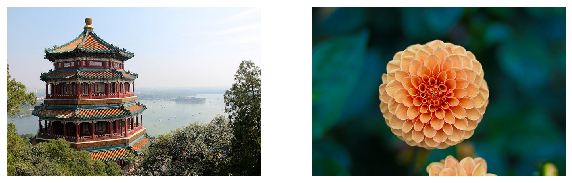

In [12]:
f, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=2)
ax[0].imshow(images[0,:,:,:])
ax[0].axis('off')
ax[1].imshow(images[1,:,:,:])
ax[1].axis('off')

Let us create two very simple filters and apply them to both images, displaying the result:

In [6]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

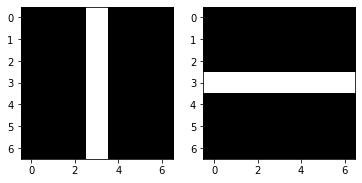

In [14]:
f, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(filters[:,:,:,0])
ax[1].imshow(filters[:,:,:,1])

In [ ]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="same")

In [ ]:
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd
feature map
plt.show()

In a CNN we use lots of these filters, but we don't want to have to specify them by hand as above. Instead, we want to learn them from our training data. The idea is to keep filtering an image and downsampling the result until we end up with a long one dimensional array of numbers (features) that we can feed to one (or more) Fully-Connected layer that will map that array to a prediction.

As an example of this, have a look at this CNN architecture, known as VGG16:

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In Keras/Tensorflow we perform downsampling with max-pooling layers:

In [ ]:
output = tf.nn.max_pool(images, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="valid")

In [ ]:
plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

## Builindg a CNN in Keras:
We will implement a simple CNN to solve the same problem as last week, namely classifying clothes in the Fashion-MNIST dataset. This is quite similar in spirit to the above picture. Let us first build the convolutional part of our model:

In [ ]:
from keras import layers
from keras import models

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Note that a CNN takes as input tensors of shape `(batch_size, image_height, image_width, image_channels)`, so we don't need to flatten the input as we did last week. In this case, we configure the CNN to process inputs of size `(28, 28, 1)`, which is the dimensions of Fashion-MNIST images. We do this by passing the argument `input_shape=(28, 28, 1)` to the first layer. Let's display the architecture of the CNN so far:

In [ ]:
model.summary()

We see that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width,channels)`. The width and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to the `Conv2D` layers (32 or 64).

The next step is to feed the last output tensor (of shape (3, 3, 64)) into a densely connected classifier network like those we saw last week: a stack of `Dense` layers. This module will process vectors, which are 1D, whereas the current output is a 3D tensor. Therefore, we first have to flatten the 3D outputs to 1D, and then add a few Dense layers on top.

We do 10-category classification, using a final layer with 10 outputs and a softmax activation. Here's what the network looks like now:

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

As you can see, the (3, 3, 64) outputs are flattened into vectors of shape `(576,)` before going through two Dense layers.

Let us now train this CNN on our data. The piece of code below is basically the same as last week:

# Transfer Learning
You will probably sometimes hear that deep learning only works when lots of data is available. This is valid in part: one fundamental characteristic of deep learning is that it can find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is particularly true for problems where the input samples are very high-dimensional, like images.

Fortunately, Deep Learning models are highly repurposable: you can take, say, an image-classification or speech-to-text model trained on a large-scale dataset and reuse it on a significantly different problem with only minor changes. Specifically in the case of computer vision, many pretrained models (usually trained on the Image-
Net dataset) are now publicly available for download and allow to train highly accurate vision models out of very little data.

We will do so now. Let us download a dataset intended to perform dogs vs cats classification. This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing it, we create a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 500 samples of each class. The pieces of code below do this for you:

In [32]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

--2020-03-30 15:24:18--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.26.148.129, 2a02:26f0:c8:38f::e59, 2a02:26f0:c8:3a8::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.26.148.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786,68M  7,92MB/s    in 1m 46s  

2020-03-30 15:26:04 (7,44 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [33]:
!unzip kagglecatsanddogs_3367a.zip

Archive:  kagglecatsanddogs_3367a.zip
   creating: PetImages/Cat/
  inflating: PetImages/Cat/0.jpg     
  inflating: PetImages/Cat/1.jpg     
  inflating: PetImages/Cat/10.jpg    
  inflating: PetImages/Cat/100.jpg   
  inflating: PetImages/Cat/1000.jpg  
  inflating: PetImages/Cat/10000.jpg  
  inflating: PetImages/Cat/10001.jpg  
  inflating: PetImages/Cat/10002.jpg  
  inflating: PetImages/Cat/10003.jpg  
  inflating: PetImages/Cat/10004.jpg  
  inflating: PetImages/Cat/10005.jpg  
  inflating: PetImages/Cat/10006.jpg  
  inflating: PetImages/Cat/10007.jpg  
  inflating: PetImages/Cat/10008.jpg  
  inflating: PetImages/Cat/10009.jpg  
  inflating: PetImages/Cat/1001.jpg  
  inflating: PetImages/Cat/10010.jpg  
  inflating: PetImages/Cat/10011.jpg  
  inflating: PetImages/Cat/10012.jpg  
  inflating: PetImages/Cat/10013.jpg  
  inflating: PetImages/Cat/10014.jpg  
  inflating: PetImages/Cat/10015.jpg  
  inflating: PetImages/Cat/10016.jpg  
  inflating: PetImages/Cat/10017.jpg  
  in

  inflating: PetImages/Cat/10200.jpg  
  inflating: PetImages/Cat/10201.jpg  
  inflating: PetImages/Cat/10202.jpg  
  inflating: PetImages/Cat/10203.jpg  
  inflating: PetImages/Cat/10204.jpg  
  inflating: PetImages/Cat/10205.jpg  
  inflating: PetImages/Cat/10206.jpg  
  inflating: PetImages/Cat/10207.jpg  
  inflating: PetImages/Cat/10208.jpg  
  inflating: PetImages/Cat/10209.jpg  
  inflating: PetImages/Cat/1021.jpg  
  inflating: PetImages/Cat/10210.jpg  
  inflating: PetImages/Cat/10211.jpg  
  inflating: PetImages/Cat/10212.jpg  
  inflating: PetImages/Cat/10213.jpg  
  inflating: PetImages/Cat/10214.jpg  
  inflating: PetImages/Cat/10215.jpg  
  inflating: PetImages/Cat/10216.jpg  
  inflating: PetImages/Cat/10217.jpg  
  inflating: PetImages/Cat/10218.jpg  
  inflating: PetImages/Cat/10219.jpg  
  inflating: PetImages/Cat/1022.jpg  
  inflating: PetImages/Cat/10220.jpg  
  inflating: PetImages/Cat/10221.jpg  
  inflating: PetImages/Cat/10222.jpg  
  inflating: PetImages/Cat/

  inflating: PetImages/Cat/10420.jpg  
  inflating: PetImages/Cat/10421.jpg  
  inflating: PetImages/Cat/10422.jpg  
  inflating: PetImages/Cat/10423.jpg  
  inflating: PetImages/Cat/10424.jpg  
  inflating: PetImages/Cat/10425.jpg  
  inflating: PetImages/Cat/10426.jpg  
  inflating: PetImages/Cat/10427.jpg  
  inflating: PetImages/Cat/10428.jpg  
  inflating: PetImages/Cat/10429.jpg  
  inflating: PetImages/Cat/1043.jpg  
  inflating: PetImages/Cat/10430.jpg  
  inflating: PetImages/Cat/10431.jpg  
  inflating: PetImages/Cat/10432.jpg  
  inflating: PetImages/Cat/10433.jpg  
  inflating: PetImages/Cat/10434.jpg  
  inflating: PetImages/Cat/10435.jpg  
  inflating: PetImages/Cat/10436.jpg  
  inflating: PetImages/Cat/10437.jpg  
  inflating: PetImages/Cat/10438.jpg  
  inflating: PetImages/Cat/10439.jpg  
  inflating: PetImages/Cat/1044.jpg  
  inflating: PetImages/Cat/10440.jpg  
  inflating: PetImages/Cat/10441.jpg  
  inflating: PetImages/Cat/10442.jpg  
  inflating: PetImages/Cat/

  inflating: PetImages/Cat/10647.jpg  
  inflating: PetImages/Cat/10648.jpg  
  inflating: PetImages/Cat/10649.jpg  
  inflating: PetImages/Cat/1065.jpg  
  inflating: PetImages/Cat/10650.jpg  
  inflating: PetImages/Cat/10651.jpg  
  inflating: PetImages/Cat/10652.jpg  
  inflating: PetImages/Cat/10653.jpg  
  inflating: PetImages/Cat/10654.jpg  
  inflating: PetImages/Cat/10655.jpg  
  inflating: PetImages/Cat/10656.jpg  
  inflating: PetImages/Cat/10657.jpg  
  inflating: PetImages/Cat/10658.jpg  
  inflating: PetImages/Cat/10659.jpg  
  inflating: PetImages/Cat/1066.jpg  
  inflating: PetImages/Cat/10660.jpg  
  inflating: PetImages/Cat/10661.jpg  
  inflating: PetImages/Cat/10662.jpg  
  inflating: PetImages/Cat/10663.jpg  
  inflating: PetImages/Cat/10664.jpg  
  inflating: PetImages/Cat/10665.jpg  
  inflating: PetImages/Cat/10666.jpg  
  inflating: PetImages/Cat/10667.jpg  
  inflating: PetImages/Cat/10668.jpg  
  inflating: PetImages/Cat/10669.jpg  
  inflating: PetImages/Cat/

  inflating: PetImages/Cat/10896.jpg  
  inflating: PetImages/Cat/10897.jpg  
  inflating: PetImages/Cat/10898.jpg  
  inflating: PetImages/Cat/10899.jpg  
  inflating: PetImages/Cat/109.jpg   
  inflating: PetImages/Cat/1090.jpg  
  inflating: PetImages/Cat/10900.jpg  
  inflating: PetImages/Cat/10901.jpg  
  inflating: PetImages/Cat/10902.jpg  
  inflating: PetImages/Cat/10903.jpg  
  inflating: PetImages/Cat/10904.jpg  
  inflating: PetImages/Cat/10905.jpg  
  inflating: PetImages/Cat/10906.jpg  
  inflating: PetImages/Cat/10907.jpg  
  inflating: PetImages/Cat/10908.jpg  
  inflating: PetImages/Cat/10909.jpg  
  inflating: PetImages/Cat/1091.jpg  
  inflating: PetImages/Cat/10910.jpg  
  inflating: PetImages/Cat/10911.jpg  
  inflating: PetImages/Cat/10912.jpg  
  inflating: PetImages/Cat/10913.jpg  
  inflating: PetImages/Cat/10914.jpg  
  inflating: PetImages/Cat/10915.jpg  
  inflating: PetImages/Cat/10916.jpg  
  inflating: PetImages/Cat/10917.jpg  
  inflating: PetImages/Cat/1

  inflating: PetImages/Cat/1112.jpg  
  inflating: PetImages/Cat/11120.jpg  
  inflating: PetImages/Cat/11121.jpg  
  inflating: PetImages/Cat/11122.jpg  
  inflating: PetImages/Cat/11123.jpg  
  inflating: PetImages/Cat/11124.jpg  
  inflating: PetImages/Cat/11125.jpg  
  inflating: PetImages/Cat/11126.jpg  
  inflating: PetImages/Cat/11127.jpg  
  inflating: PetImages/Cat/11128.jpg  
  inflating: PetImages/Cat/11129.jpg  
  inflating: PetImages/Cat/1113.jpg  
  inflating: PetImages/Cat/11130.jpg  
  inflating: PetImages/Cat/11131.jpg  
  inflating: PetImages/Cat/11132.jpg  
  inflating: PetImages/Cat/11133.jpg  
  inflating: PetImages/Cat/11134.jpg  
  inflating: PetImages/Cat/11135.jpg  
  inflating: PetImages/Cat/11136.jpg  
  inflating: PetImages/Cat/11137.jpg  
  inflating: PetImages/Cat/11138.jpg  
  inflating: PetImages/Cat/11139.jpg  
  inflating: PetImages/Cat/1114.jpg  
  inflating: PetImages/Cat/11140.jpg  
  inflating: PetImages/Cat/11141.jpg  
  inflating: PetImages/Cat/1

  inflating: PetImages/Cat/11360.jpg  
  inflating: PetImages/Cat/11361.jpg  
  inflating: PetImages/Cat/11362.jpg  
  inflating: PetImages/Cat/11363.jpg  
  inflating: PetImages/Cat/11364.jpg  
  inflating: PetImages/Cat/11365.jpg  
  inflating: PetImages/Cat/11366.jpg  
  inflating: PetImages/Cat/11367.jpg  
  inflating: PetImages/Cat/11368.jpg  
  inflating: PetImages/Cat/11369.jpg  
  inflating: PetImages/Cat/1137.jpg  
  inflating: PetImages/Cat/11370.jpg  
  inflating: PetImages/Cat/11371.jpg  
  inflating: PetImages/Cat/11372.jpg  
  inflating: PetImages/Cat/11373.jpg  
  inflating: PetImages/Cat/11374.jpg  
  inflating: PetImages/Cat/11375.jpg  
  inflating: PetImages/Cat/11376.jpg  
  inflating: PetImages/Cat/11377.jpg  
  inflating: PetImages/Cat/11378.jpg  
  inflating: PetImages/Cat/11379.jpg  
  inflating: PetImages/Cat/1138.jpg  
  inflating: PetImages/Cat/11380.jpg  
  inflating: PetImages/Cat/11381.jpg  
  inflating: PetImages/Cat/11382.jpg  
  inflating: PetImages/Cat/

  inflating: PetImages/Cat/11593.jpg  
  inflating: PetImages/Cat/11594.jpg  
  inflating: PetImages/Cat/11595.jpg  
  inflating: PetImages/Cat/11596.jpg  
  inflating: PetImages/Cat/11597.jpg  
  inflating: PetImages/Cat/11598.jpg  
  inflating: PetImages/Cat/11599.jpg  
  inflating: PetImages/Cat/116.jpg   
  inflating: PetImages/Cat/1160.jpg  
  inflating: PetImages/Cat/11600.jpg  
  inflating: PetImages/Cat/11601.jpg  
  inflating: PetImages/Cat/11602.jpg  
  inflating: PetImages/Cat/11603.jpg  
  inflating: PetImages/Cat/11604.jpg  
  inflating: PetImages/Cat/11605.jpg  
  inflating: PetImages/Cat/11606.jpg  
  inflating: PetImages/Cat/11607.jpg  
  inflating: PetImages/Cat/11608.jpg  
  inflating: PetImages/Cat/11609.jpg  
  inflating: PetImages/Cat/1161.jpg  
  inflating: PetImages/Cat/11610.jpg  
  inflating: PetImages/Cat/11611.jpg  
  inflating: PetImages/Cat/11612.jpg  
  inflating: PetImages/Cat/11613.jpg  
  inflating: PetImages/Cat/11614.jpg  
  inflating: PetImages/Cat/1

  inflating: PetImages/Cat/11846.jpg  
  inflating: PetImages/Cat/11847.jpg  
  inflating: PetImages/Cat/11848.jpg  
  inflating: PetImages/Cat/11849.jpg  
  inflating: PetImages/Cat/1185.jpg  
  inflating: PetImages/Cat/11850.jpg  
  inflating: PetImages/Cat/11851.jpg  
  inflating: PetImages/Cat/11852.jpg  
  inflating: PetImages/Cat/11853.jpg  
  inflating: PetImages/Cat/11854.jpg  
  inflating: PetImages/Cat/11855.jpg  
  inflating: PetImages/Cat/11856.jpg  
  inflating: PetImages/Cat/11857.jpg  
  inflating: PetImages/Cat/11858.jpg  
  inflating: PetImages/Cat/11859.jpg  
  inflating: PetImages/Cat/1186.jpg  
  inflating: PetImages/Cat/11860.jpg  
  inflating: PetImages/Cat/11861.jpg  
  inflating: PetImages/Cat/11862.jpg  
  inflating: PetImages/Cat/11863.jpg  
  inflating: PetImages/Cat/11864.jpg  
  inflating: PetImages/Cat/11865.jpg  
  inflating: PetImages/Cat/11866.jpg  
  inflating: PetImages/Cat/11867.jpg  
  inflating: PetImages/Cat/11868.jpg  
  inflating: PetImages/Cat/

  inflating: PetImages/Cat/12092.jpg  
  inflating: PetImages/Cat/12093.jpg  
  inflating: PetImages/Cat/12094.jpg  
  inflating: PetImages/Cat/12095.jpg  
  inflating: PetImages/Cat/12096.jpg  
  inflating: PetImages/Cat/12097.jpg  
  inflating: PetImages/Cat/12098.jpg  
  inflating: PetImages/Cat/12099.jpg  
  inflating: PetImages/Cat/121.jpg   
  inflating: PetImages/Cat/1210.jpg  
  inflating: PetImages/Cat/12100.jpg  
  inflating: PetImages/Cat/12101.jpg  
  inflating: PetImages/Cat/12102.jpg  
  inflating: PetImages/Cat/12103.jpg  
  inflating: PetImages/Cat/12104.jpg  
  inflating: PetImages/Cat/12105.jpg  
  inflating: PetImages/Cat/12106.jpg  
  inflating: PetImages/Cat/12107.jpg  
  inflating: PetImages/Cat/12108.jpg  
  inflating: PetImages/Cat/12109.jpg  
  inflating: PetImages/Cat/1211.jpg  
  inflating: PetImages/Cat/12110.jpg  
  inflating: PetImages/Cat/12111.jpg  
  inflating: PetImages/Cat/12112.jpg  
  inflating: PetImages/Cat/12113.jpg  
  inflating: PetImages/Cat/1

  inflating: PetImages/Cat/12311.jpg  
  inflating: PetImages/Cat/12312.jpg  
  inflating: PetImages/Cat/12313.jpg  
  inflating: PetImages/Cat/12314.jpg  
  inflating: PetImages/Cat/12315.jpg  
  inflating: PetImages/Cat/12316.jpg  
  inflating: PetImages/Cat/12317.jpg  
  inflating: PetImages/Cat/12318.jpg  
  inflating: PetImages/Cat/12319.jpg  
  inflating: PetImages/Cat/1232.jpg  
  inflating: PetImages/Cat/12320.jpg  
  inflating: PetImages/Cat/12321.jpg  
  inflating: PetImages/Cat/12322.jpg  
  inflating: PetImages/Cat/12323.jpg  
  inflating: PetImages/Cat/12324.jpg  
  inflating: PetImages/Cat/12325.jpg  
  inflating: PetImages/Cat/12326.jpg  
  inflating: PetImages/Cat/12327.jpg  
  inflating: PetImages/Cat/12328.jpg  
  inflating: PetImages/Cat/12329.jpg  
  inflating: PetImages/Cat/1233.jpg  
  inflating: PetImages/Cat/12330.jpg  
  inflating: PetImages/Cat/12331.jpg  
  inflating: PetImages/Cat/12332.jpg  
  inflating: PetImages/Cat/12333.jpg  
  inflating: PetImages/Cat/

  inflating: PetImages/Cat/132.jpg   
  inflating: PetImages/Cat/1320.jpg  
  inflating: PetImages/Cat/1321.jpg  
  inflating: PetImages/Cat/1322.jpg  
  inflating: PetImages/Cat/1323.jpg  
  inflating: PetImages/Cat/1324.jpg  
  inflating: PetImages/Cat/1325.jpg  
  inflating: PetImages/Cat/1326.jpg  
  inflating: PetImages/Cat/1327.jpg  
  inflating: PetImages/Cat/1328.jpg  
  inflating: PetImages/Cat/1329.jpg  
  inflating: PetImages/Cat/133.jpg   
  inflating: PetImages/Cat/1330.jpg  
  inflating: PetImages/Cat/1331.jpg  
  inflating: PetImages/Cat/1332.jpg  
  inflating: PetImages/Cat/1333.jpg  
  inflating: PetImages/Cat/1334.jpg  
  inflating: PetImages/Cat/1335.jpg  
  inflating: PetImages/Cat/1336.jpg  
  inflating: PetImages/Cat/1337.jpg  
  inflating: PetImages/Cat/1338.jpg  
  inflating: PetImages/Cat/1339.jpg  
  inflating: PetImages/Cat/134.jpg   
  inflating: PetImages/Cat/1340.jpg  
  inflating: PetImages/Cat/1341.jpg  
  inflating: PetImages/Cat/1342.jpg  
  inflating:

  inflating: PetImages/Cat/1585.jpg  
  inflating: PetImages/Cat/1586.jpg  
  inflating: PetImages/Cat/1587.jpg  
  inflating: PetImages/Cat/1588.jpg  
  inflating: PetImages/Cat/1589.jpg  
  inflating: PetImages/Cat/159.jpg   
  inflating: PetImages/Cat/1590.jpg  
  inflating: PetImages/Cat/1591.jpg  
  inflating: PetImages/Cat/1592.jpg  
  inflating: PetImages/Cat/1593.jpg  
  inflating: PetImages/Cat/1594.jpg  
  inflating: PetImages/Cat/1595.jpg  
  inflating: PetImages/Cat/1596.jpg  
  inflating: PetImages/Cat/1597.jpg  
  inflating: PetImages/Cat/1598.jpg  
  inflating: PetImages/Cat/1599.jpg  
  inflating: PetImages/Cat/16.jpg    
  inflating: PetImages/Cat/160.jpg   
  inflating: PetImages/Cat/1600.jpg  
  inflating: PetImages/Cat/1601.jpg  
  inflating: PetImages/Cat/1602.jpg  
  inflating: PetImages/Cat/1603.jpg  
  inflating: PetImages/Cat/1604.jpg  
  inflating: PetImages/Cat/1605.jpg  
  inflating: PetImages/Cat/1606.jpg  
  inflating: PetImages/Cat/1607.jpg  
  inflating:

  inflating: PetImages/Cat/1796.jpg  
  inflating: PetImages/Cat/1797.jpg  
  inflating: PetImages/Cat/1798.jpg  
  inflating: PetImages/Cat/1799.jpg  
  inflating: PetImages/Cat/18.jpg    
  inflating: PetImages/Cat/180.jpg   
  inflating: PetImages/Cat/1800.jpg  
  inflating: PetImages/Cat/1801.jpg  
  inflating: PetImages/Cat/1802.jpg  
  inflating: PetImages/Cat/1803.jpg  
  inflating: PetImages/Cat/1804.jpg  
  inflating: PetImages/Cat/1805.jpg  
  inflating: PetImages/Cat/1806.jpg  
  inflating: PetImages/Cat/1807.jpg  
  inflating: PetImages/Cat/1808.jpg  
  inflating: PetImages/Cat/1809.jpg  
  inflating: PetImages/Cat/181.jpg   
  inflating: PetImages/Cat/1810.jpg  
  inflating: PetImages/Cat/1811.jpg  
  inflating: PetImages/Cat/1812.jpg  
  inflating: PetImages/Cat/1813.jpg  
  inflating: PetImages/Cat/1814.jpg  
  inflating: PetImages/Cat/1815.jpg  
  inflating: PetImages/Cat/1816.jpg  
  inflating: PetImages/Cat/1817.jpg  
  inflating: PetImages/Cat/1818.jpg  
  inflating:

  inflating: PetImages/Cat/2021.jpg  
  inflating: PetImages/Cat/2022.jpg  
  inflating: PetImages/Cat/2023.jpg  
  inflating: PetImages/Cat/2024.jpg  
  inflating: PetImages/Cat/2025.jpg  
  inflating: PetImages/Cat/2026.jpg  
  inflating: PetImages/Cat/2027.jpg  
  inflating: PetImages/Cat/2028.jpg  
  inflating: PetImages/Cat/2029.jpg  
  inflating: PetImages/Cat/203.jpg   
  inflating: PetImages/Cat/2030.jpg  
  inflating: PetImages/Cat/2031.jpg  
  inflating: PetImages/Cat/2032.jpg  
  inflating: PetImages/Cat/2033.jpg  
  inflating: PetImages/Cat/2034.jpg  
  inflating: PetImages/Cat/2035.jpg  
  inflating: PetImages/Cat/2036.jpg  
  inflating: PetImages/Cat/2037.jpg  
  inflating: PetImages/Cat/2038.jpg  
  inflating: PetImages/Cat/2039.jpg  
  inflating: PetImages/Cat/204.jpg   
  inflating: PetImages/Cat/2040.jpg  
  inflating: PetImages/Cat/2041.jpg  
  inflating: PetImages/Cat/2042.jpg  
  inflating: PetImages/Cat/2043.jpg  
  inflating: PetImages/Cat/2044.jpg  
  inflating:

  inflating: PetImages/Cat/2250.jpg  
  inflating: PetImages/Cat/2251.jpg  
  inflating: PetImages/Cat/2252.jpg  
  inflating: PetImages/Cat/2253.jpg  
  inflating: PetImages/Cat/2254.jpg  
  inflating: PetImages/Cat/2255.jpg  
  inflating: PetImages/Cat/2256.jpg  
  inflating: PetImages/Cat/2257.jpg  
  inflating: PetImages/Cat/2258.jpg  
  inflating: PetImages/Cat/2259.jpg  
  inflating: PetImages/Cat/226.jpg   
  inflating: PetImages/Cat/2260.jpg  
  inflating: PetImages/Cat/2261.jpg  
  inflating: PetImages/Cat/2262.jpg  
  inflating: PetImages/Cat/2263.jpg  
  inflating: PetImages/Cat/2264.jpg  
  inflating: PetImages/Cat/2265.jpg  
  inflating: PetImages/Cat/2266.jpg  
  inflating: PetImages/Cat/2267.jpg  
  inflating: PetImages/Cat/2268.jpg  
  inflating: PetImages/Cat/2269.jpg  
  inflating: PetImages/Cat/227.jpg   
  inflating: PetImages/Cat/2270.jpg  
  inflating: PetImages/Cat/2271.jpg  
  inflating: PetImages/Cat/2272.jpg  
  inflating: PetImages/Cat/2273.jpg  
  inflating:

  inflating: PetImages/Cat/2499.jpg  
  inflating: PetImages/Cat/25.jpg    
  inflating: PetImages/Cat/250.jpg   
  inflating: PetImages/Cat/2500.jpg  
  inflating: PetImages/Cat/2501.jpg  
  inflating: PetImages/Cat/2502.jpg  
  inflating: PetImages/Cat/2503.jpg  
  inflating: PetImages/Cat/2504.jpg  
  inflating: PetImages/Cat/2505.jpg  
  inflating: PetImages/Cat/2506.jpg  
  inflating: PetImages/Cat/2507.jpg  
  inflating: PetImages/Cat/2508.jpg  
  inflating: PetImages/Cat/2509.jpg  
  inflating: PetImages/Cat/251.jpg   
  inflating: PetImages/Cat/2510.jpg  
  inflating: PetImages/Cat/2511.jpg  
  inflating: PetImages/Cat/2512.jpg  
  inflating: PetImages/Cat/2513.jpg  
  inflating: PetImages/Cat/2514.jpg  
  inflating: PetImages/Cat/2515.jpg  
  inflating: PetImages/Cat/2516.jpg  
  inflating: PetImages/Cat/2517.jpg  
  inflating: PetImages/Cat/2518.jpg  
  inflating: PetImages/Cat/2519.jpg  
  inflating: PetImages/Cat/252.jpg   
  inflating: PetImages/Cat/2520.jpg  
  inflating:

  inflating: PetImages/Cat/2743.jpg  
  inflating: PetImages/Cat/2744.jpg  
  inflating: PetImages/Cat/2745.jpg  
  inflating: PetImages/Cat/2746.jpg  
  inflating: PetImages/Cat/2747.jpg  
  inflating: PetImages/Cat/2748.jpg  
  inflating: PetImages/Cat/2749.jpg  
  inflating: PetImages/Cat/275.jpg   
  inflating: PetImages/Cat/2750.jpg  
  inflating: PetImages/Cat/2751.jpg  
  inflating: PetImages/Cat/2752.jpg  
  inflating: PetImages/Cat/2753.jpg  
  inflating: PetImages/Cat/2754.jpg  
  inflating: PetImages/Cat/2755.jpg  
  inflating: PetImages/Cat/2756.jpg  
  inflating: PetImages/Cat/2757.jpg  
  inflating: PetImages/Cat/2758.jpg  
  inflating: PetImages/Cat/2759.jpg  
  inflating: PetImages/Cat/276.jpg   
  inflating: PetImages/Cat/2760.jpg  
  inflating: PetImages/Cat/2761.jpg  
  inflating: PetImages/Cat/2762.jpg  
  inflating: PetImages/Cat/2763.jpg  
  inflating: PetImages/Cat/2764.jpg  
  inflating: PetImages/Cat/2765.jpg  
  inflating: PetImages/Cat/2766.jpg  
  inflating:

  inflating: PetImages/Cat/3000.jpg  
  inflating: PetImages/Cat/3001.jpg  
  inflating: PetImages/Cat/3002.jpg  
  inflating: PetImages/Cat/3003.jpg  
  inflating: PetImages/Cat/3004.jpg  
  inflating: PetImages/Cat/3005.jpg  
  inflating: PetImages/Cat/3006.jpg  
  inflating: PetImages/Cat/3007.jpg  
  inflating: PetImages/Cat/3008.jpg  
  inflating: PetImages/Cat/3009.jpg  
  inflating: PetImages/Cat/301.jpg   
  inflating: PetImages/Cat/3010.jpg  
  inflating: PetImages/Cat/3011.jpg  
  inflating: PetImages/Cat/3012.jpg  
  inflating: PetImages/Cat/3013.jpg  
  inflating: PetImages/Cat/3014.jpg  
  inflating: PetImages/Cat/3015.jpg  
  inflating: PetImages/Cat/3016.jpg  
  inflating: PetImages/Cat/3017.jpg  
  inflating: PetImages/Cat/3018.jpg  
  inflating: PetImages/Cat/3019.jpg  
  inflating: PetImages/Cat/302.jpg   
  inflating: PetImages/Cat/3020.jpg  
  inflating: PetImages/Cat/3021.jpg  
  inflating: PetImages/Cat/3022.jpg  
  inflating: PetImages/Cat/3023.jpg  
  inflating:

  inflating: PetImages/Cat/3289.jpg  
  inflating: PetImages/Cat/329.jpg   
  inflating: PetImages/Cat/3290.jpg  
  inflating: PetImages/Cat/3291.jpg  
  inflating: PetImages/Cat/3292.jpg  
  inflating: PetImages/Cat/3293.jpg  
  inflating: PetImages/Cat/3294.jpg  
  inflating: PetImages/Cat/3295.jpg  
  inflating: PetImages/Cat/3296.jpg  
  inflating: PetImages/Cat/3297.jpg  
  inflating: PetImages/Cat/3298.jpg  
  inflating: PetImages/Cat/3299.jpg  
  inflating: PetImages/Cat/33.jpg    
  inflating: PetImages/Cat/330.jpg   
  inflating: PetImages/Cat/3300.jpg  
  inflating: PetImages/Cat/3301.jpg  
  inflating: PetImages/Cat/3302.jpg  
  inflating: PetImages/Cat/3303.jpg  
  inflating: PetImages/Cat/3304.jpg  
  inflating: PetImages/Cat/3305.jpg  
  inflating: PetImages/Cat/3306.jpg  
  inflating: PetImages/Cat/3307.jpg  
  inflating: PetImages/Cat/3308.jpg  
  inflating: PetImages/Cat/3309.jpg  
  inflating: PetImages/Cat/331.jpg   
  inflating: PetImages/Cat/3310.jpg  
  inflating:

  inflating: PetImages/Cat/3521.jpg  
  inflating: PetImages/Cat/3522.jpg  
  inflating: PetImages/Cat/3523.jpg  
  inflating: PetImages/Cat/3524.jpg  
  inflating: PetImages/Cat/3525.jpg  
  inflating: PetImages/Cat/3526.jpg  
  inflating: PetImages/Cat/3527.jpg  
  inflating: PetImages/Cat/3528.jpg  
  inflating: PetImages/Cat/3529.jpg  
  inflating: PetImages/Cat/353.jpg   
  inflating: PetImages/Cat/3530.jpg  
  inflating: PetImages/Cat/3531.jpg  
  inflating: PetImages/Cat/3532.jpg  
  inflating: PetImages/Cat/3533.jpg  
  inflating: PetImages/Cat/3534.jpg  
  inflating: PetImages/Cat/3535.jpg  
  inflating: PetImages/Cat/3536.jpg  
  inflating: PetImages/Cat/3537.jpg  
  inflating: PetImages/Cat/3538.jpg  
  inflating: PetImages/Cat/3539.jpg  
  inflating: PetImages/Cat/354.jpg   
  inflating: PetImages/Cat/3540.jpg  
  inflating: PetImages/Cat/3541.jpg  
  inflating: PetImages/Cat/3542.jpg  
  inflating: PetImages/Cat/3543.jpg  
  inflating: PetImages/Cat/3544.jpg  
  inflating:

  inflating: PetImages/Cat/3738.jpg  
  inflating: PetImages/Cat/3739.jpg  
  inflating: PetImages/Cat/374.jpg   
  inflating: PetImages/Cat/3740.jpg  
  inflating: PetImages/Cat/3741.jpg  
  inflating: PetImages/Cat/3742.jpg  
  inflating: PetImages/Cat/3743.jpg  
  inflating: PetImages/Cat/3744.jpg  
  inflating: PetImages/Cat/3745.jpg  
  inflating: PetImages/Cat/3746.jpg  
  inflating: PetImages/Cat/3747.jpg  
  inflating: PetImages/Cat/3748.jpg  
  inflating: PetImages/Cat/3749.jpg  
  inflating: PetImages/Cat/375.jpg   
  inflating: PetImages/Cat/3750.jpg  
  inflating: PetImages/Cat/3751.jpg  
  inflating: PetImages/Cat/3752.jpg  
  inflating: PetImages/Cat/3753.jpg  
  inflating: PetImages/Cat/3754.jpg  
  inflating: PetImages/Cat/3755.jpg  
  inflating: PetImages/Cat/3756.jpg  
  inflating: PetImages/Cat/3757.jpg  
  inflating: PetImages/Cat/3758.jpg  
  inflating: PetImages/Cat/3759.jpg  
  inflating: PetImages/Cat/376.jpg   
  inflating: PetImages/Cat/3760.jpg  
  inflating:

  inflating: PetImages/Cat/3971.jpg  
  inflating: PetImages/Cat/3972.jpg  
  inflating: PetImages/Cat/3973.jpg  
  inflating: PetImages/Cat/3974.jpg  
  inflating: PetImages/Cat/3975.jpg  
  inflating: PetImages/Cat/3976.jpg  
  inflating: PetImages/Cat/3977.jpg  
  inflating: PetImages/Cat/3978.jpg  
  inflating: PetImages/Cat/3979.jpg  
  inflating: PetImages/Cat/398.jpg   
  inflating: PetImages/Cat/3980.jpg  
  inflating: PetImages/Cat/3981.jpg  
  inflating: PetImages/Cat/3982.jpg  
  inflating: PetImages/Cat/3983.jpg  
  inflating: PetImages/Cat/3984.jpg  
  inflating: PetImages/Cat/3985.jpg  
  inflating: PetImages/Cat/3986.jpg  
  inflating: PetImages/Cat/3987.jpg  
  inflating: PetImages/Cat/3988.jpg  
  inflating: PetImages/Cat/3989.jpg  
  inflating: PetImages/Cat/399.jpg   
  inflating: PetImages/Cat/3990.jpg  
  inflating: PetImages/Cat/3991.jpg  
  inflating: PetImages/Cat/3992.jpg  
  inflating: PetImages/Cat/3993.jpg  
  inflating: PetImages/Cat/3994.jpg  
  inflating:

  inflating: PetImages/Cat/4219.jpg  
  inflating: PetImages/Cat/422.jpg   
  inflating: PetImages/Cat/4220.jpg  
  inflating: PetImages/Cat/4221.jpg  
  inflating: PetImages/Cat/4222.jpg  
  inflating: PetImages/Cat/4223.jpg  
  inflating: PetImages/Cat/4224.jpg  
  inflating: PetImages/Cat/4225.jpg  
  inflating: PetImages/Cat/4226.jpg  
  inflating: PetImages/Cat/4227.jpg  
  inflating: PetImages/Cat/4228.jpg  
  inflating: PetImages/Cat/4229.jpg  
  inflating: PetImages/Cat/423.jpg   
  inflating: PetImages/Cat/4230.jpg  
  inflating: PetImages/Cat/4231.jpg  
  inflating: PetImages/Cat/4232.jpg  
  inflating: PetImages/Cat/4233.jpg  
  inflating: PetImages/Cat/4234.jpg  
  inflating: PetImages/Cat/4235.jpg  
  inflating: PetImages/Cat/4236.jpg  
  inflating: PetImages/Cat/4237.jpg  
  inflating: PetImages/Cat/4238.jpg  
  inflating: PetImages/Cat/4239.jpg  
  inflating: PetImages/Cat/424.jpg   
  inflating: PetImages/Cat/4240.jpg  
  inflating: PetImages/Cat/4241.jpg  
  inflating:

  inflating: PetImages/Cat/4416.jpg  
  inflating: PetImages/Cat/4417.jpg  
  inflating: PetImages/Cat/4418.jpg  
  inflating: PetImages/Cat/4419.jpg  
  inflating: PetImages/Cat/442.jpg   
  inflating: PetImages/Cat/4420.jpg  
  inflating: PetImages/Cat/4421.jpg  
  inflating: PetImages/Cat/4422.jpg  
  inflating: PetImages/Cat/4423.jpg  
  inflating: PetImages/Cat/4424.jpg  
  inflating: PetImages/Cat/4425.jpg  
  inflating: PetImages/Cat/4426.jpg  
  inflating: PetImages/Cat/4427.jpg  
  inflating: PetImages/Cat/4428.jpg  
  inflating: PetImages/Cat/4429.jpg  
  inflating: PetImages/Cat/443.jpg   
  inflating: PetImages/Cat/4430.jpg  
  inflating: PetImages/Cat/4431.jpg  
  inflating: PetImages/Cat/4432.jpg  
  inflating: PetImages/Cat/4433.jpg  
  inflating: PetImages/Cat/4434.jpg  
  inflating: PetImages/Cat/4435.jpg  
  inflating: PetImages/Cat/4436.jpg  
  inflating: PetImages/Cat/4437.jpg  
  inflating: PetImages/Cat/4438.jpg  
  inflating: PetImages/Cat/4439.jpg  
  inflating:

  inflating: PetImages/Cat/4611.jpg  
  inflating: PetImages/Cat/4612.jpg  
  inflating: PetImages/Cat/4613.jpg  
  inflating: PetImages/Cat/4614.jpg  
  inflating: PetImages/Cat/4615.jpg  
  inflating: PetImages/Cat/4616.jpg  
  inflating: PetImages/Cat/4617.jpg  
  inflating: PetImages/Cat/4618.jpg  
  inflating: PetImages/Cat/4619.jpg  
  inflating: PetImages/Cat/462.jpg   
  inflating: PetImages/Cat/4620.jpg  
  inflating: PetImages/Cat/4621.jpg  
  inflating: PetImages/Cat/4622.jpg  
  inflating: PetImages/Cat/4623.jpg  
  inflating: PetImages/Cat/4624.jpg  
  inflating: PetImages/Cat/4625.jpg  
  inflating: PetImages/Cat/4626.jpg  
  inflating: PetImages/Cat/4627.jpg  
  inflating: PetImages/Cat/4628.jpg  
  inflating: PetImages/Cat/4629.jpg  
  inflating: PetImages/Cat/463.jpg   
  inflating: PetImages/Cat/4630.jpg  
  inflating: PetImages/Cat/4631.jpg  
  inflating: PetImages/Cat/4632.jpg  
  inflating: PetImages/Cat/4633.jpg  
  inflating: PetImages/Cat/4634.jpg  
  inflating:

  inflating: PetImages/Cat/4892.jpg  
  inflating: PetImages/Cat/4893.jpg  
  inflating: PetImages/Cat/4894.jpg  
  inflating: PetImages/Cat/4895.jpg  
  inflating: PetImages/Cat/4896.jpg  
  inflating: PetImages/Cat/4897.jpg  
  inflating: PetImages/Cat/4898.jpg  
  inflating: PetImages/Cat/4899.jpg  
  inflating: PetImages/Cat/49.jpg    
  inflating: PetImages/Cat/490.jpg   
  inflating: PetImages/Cat/4900.jpg  
  inflating: PetImages/Cat/4901.jpg  
  inflating: PetImages/Cat/4902.jpg  
  inflating: PetImages/Cat/4903.jpg  
  inflating: PetImages/Cat/4904.jpg  
  inflating: PetImages/Cat/4905.jpg  
  inflating: PetImages/Cat/4906.jpg  
  inflating: PetImages/Cat/4907.jpg  
  inflating: PetImages/Cat/4908.jpg  
  inflating: PetImages/Cat/4909.jpg  
  inflating: PetImages/Cat/491.jpg   
  inflating: PetImages/Cat/4910.jpg  
  inflating: PetImages/Cat/4911.jpg  
  inflating: PetImages/Cat/4912.jpg  
  inflating: PetImages/Cat/4913.jpg  
  inflating: PetImages/Cat/4914.jpg  
  inflating:

  inflating: PetImages/Cat/5117.jpg  
  inflating: PetImages/Cat/5118.jpg  
  inflating: PetImages/Cat/5119.jpg  
  inflating: PetImages/Cat/512.jpg   
  inflating: PetImages/Cat/5120.jpg  
  inflating: PetImages/Cat/5121.jpg  
  inflating: PetImages/Cat/5122.jpg  
  inflating: PetImages/Cat/5123.jpg  
  inflating: PetImages/Cat/5124.jpg  
  inflating: PetImages/Cat/5125.jpg  
  inflating: PetImages/Cat/5126.jpg  
  inflating: PetImages/Cat/5127.jpg  
  inflating: PetImages/Cat/5128.jpg  
  inflating: PetImages/Cat/5129.jpg  
  inflating: PetImages/Cat/513.jpg   
  inflating: PetImages/Cat/5130.jpg  
  inflating: PetImages/Cat/5131.jpg  
  inflating: PetImages/Cat/5132.jpg  
  inflating: PetImages/Cat/5133.jpg  
  inflating: PetImages/Cat/5134.jpg  
  inflating: PetImages/Cat/5135.jpg  
  inflating: PetImages/Cat/5136.jpg  
  inflating: PetImages/Cat/5137.jpg  
  inflating: PetImages/Cat/5138.jpg  
  inflating: PetImages/Cat/5139.jpg  
  inflating: PetImages/Cat/514.jpg   
  inflating:

  inflating: PetImages/Cat/5349.jpg  
  inflating: PetImages/Cat/535.jpg   
  inflating: PetImages/Cat/5350.jpg  
  inflating: PetImages/Cat/5351.jpg  
  inflating: PetImages/Cat/5352.jpg  
  inflating: PetImages/Cat/5353.jpg  
  inflating: PetImages/Cat/5354.jpg  
  inflating: PetImages/Cat/5355.jpg  
  inflating: PetImages/Cat/5356.jpg  
  inflating: PetImages/Cat/5357.jpg  
  inflating: PetImages/Cat/5358.jpg  
  inflating: PetImages/Cat/5359.jpg  
  inflating: PetImages/Cat/536.jpg   
  inflating: PetImages/Cat/5360.jpg  
  inflating: PetImages/Cat/5361.jpg  
  inflating: PetImages/Cat/5362.jpg  
  inflating: PetImages/Cat/5363.jpg  
  inflating: PetImages/Cat/5364.jpg  
  inflating: PetImages/Cat/5365.jpg  
  inflating: PetImages/Cat/5366.jpg  
  inflating: PetImages/Cat/5367.jpg  
  inflating: PetImages/Cat/5368.jpg  
  inflating: PetImages/Cat/5369.jpg  
  inflating: PetImages/Cat/537.jpg   
  inflating: PetImages/Cat/5370.jpg  
  inflating: PetImages/Cat/5371.jpg  
  inflating:

  inflating: PetImages/Cat/5579.jpg  
  inflating: PetImages/Cat/558.jpg   
  inflating: PetImages/Cat/5580.jpg  
  inflating: PetImages/Cat/5581.jpg  
  inflating: PetImages/Cat/5582.jpg  
  inflating: PetImages/Cat/5583.jpg  
  inflating: PetImages/Cat/5584.jpg  
  inflating: PetImages/Cat/5585.jpg  
  inflating: PetImages/Cat/5586.jpg  
  inflating: PetImages/Cat/5587.jpg  
  inflating: PetImages/Cat/5588.jpg  
  inflating: PetImages/Cat/5589.jpg  
  inflating: PetImages/Cat/559.jpg   
  inflating: PetImages/Cat/5590.jpg  
  inflating: PetImages/Cat/5591.jpg  
  inflating: PetImages/Cat/5592.jpg  
  inflating: PetImages/Cat/5593.jpg  
  inflating: PetImages/Cat/5594.jpg  
  inflating: PetImages/Cat/5595.jpg  
  inflating: PetImages/Cat/5596.jpg  
  inflating: PetImages/Cat/5597.jpg  
  inflating: PetImages/Cat/5598.jpg  
  inflating: PetImages/Cat/5599.jpg  
  inflating: PetImages/Cat/56.jpg    
  inflating: PetImages/Cat/560.jpg   
  inflating: PetImages/Cat/5600.jpg  
  inflating:

  inflating: PetImages/Cat/5819.jpg  
  inflating: PetImages/Cat/582.jpg   
  inflating: PetImages/Cat/5820.jpg  
  inflating: PetImages/Cat/5821.jpg  
  inflating: PetImages/Cat/5822.jpg  
  inflating: PetImages/Cat/5823.jpg  
  inflating: PetImages/Cat/5824.jpg  
  inflating: PetImages/Cat/5825.jpg  
  inflating: PetImages/Cat/5826.jpg  
  inflating: PetImages/Cat/5827.jpg  
  inflating: PetImages/Cat/5828.jpg  
  inflating: PetImages/Cat/5829.jpg  
  inflating: PetImages/Cat/583.jpg   
  inflating: PetImages/Cat/5830.jpg  
  inflating: PetImages/Cat/5831.jpg  
  inflating: PetImages/Cat/5832.jpg  
  inflating: PetImages/Cat/5833.jpg  
  inflating: PetImages/Cat/5834.jpg  
  inflating: PetImages/Cat/5835.jpg  
  inflating: PetImages/Cat/5836.jpg  
  inflating: PetImages/Cat/5837.jpg  
  inflating: PetImages/Cat/5838.jpg  
  inflating: PetImages/Cat/5839.jpg  
  inflating: PetImages/Cat/584.jpg   
  inflating: PetImages/Cat/5840.jpg  
  inflating: PetImages/Cat/5841.jpg  
  inflating:

  inflating: PetImages/Cat/6055.jpg  
  inflating: PetImages/Cat/6056.jpg  
  inflating: PetImages/Cat/6057.jpg  
  inflating: PetImages/Cat/6058.jpg  
  inflating: PetImages/Cat/6059.jpg  
  inflating: PetImages/Cat/606.jpg   
  inflating: PetImages/Cat/6060.jpg  
  inflating: PetImages/Cat/6061.jpg  
  inflating: PetImages/Cat/6062.jpg  
  inflating: PetImages/Cat/6063.jpg  
  inflating: PetImages/Cat/6064.jpg  
  inflating: PetImages/Cat/6065.jpg  
  inflating: PetImages/Cat/6066.jpg  
  inflating: PetImages/Cat/6067.jpg  
  inflating: PetImages/Cat/6068.jpg  
  inflating: PetImages/Cat/6069.jpg  
  inflating: PetImages/Cat/607.jpg   
  inflating: PetImages/Cat/6070.jpg  
  inflating: PetImages/Cat/6071.jpg  
  inflating: PetImages/Cat/6072.jpg  
  inflating: PetImages/Cat/6073.jpg  
  inflating: PetImages/Cat/6074.jpg  
  inflating: PetImages/Cat/6075.jpg  
  inflating: PetImages/Cat/6076.jpg  
  inflating: PetImages/Cat/6077.jpg  
  inflating: PetImages/Cat/6078.jpg  
  inflating:

  inflating: PetImages/Cat/6301.jpg  
  inflating: PetImages/Cat/6302.jpg  
  inflating: PetImages/Cat/6303.jpg  
  inflating: PetImages/Cat/6304.jpg  
  inflating: PetImages/Cat/6305.jpg  
  inflating: PetImages/Cat/6306.jpg  
  inflating: PetImages/Cat/6307.jpg  
  inflating: PetImages/Cat/6308.jpg  
  inflating: PetImages/Cat/6309.jpg  
  inflating: PetImages/Cat/631.jpg   
  inflating: PetImages/Cat/6310.jpg  
  inflating: PetImages/Cat/6311.jpg  
  inflating: PetImages/Cat/6312.jpg  
  inflating: PetImages/Cat/6313.jpg  
  inflating: PetImages/Cat/6314.jpg  
  inflating: PetImages/Cat/6315.jpg  
  inflating: PetImages/Cat/6316.jpg  
  inflating: PetImages/Cat/6317.jpg  
  inflating: PetImages/Cat/6318.jpg  
  inflating: PetImages/Cat/6319.jpg  
  inflating: PetImages/Cat/632.jpg   
  inflating: PetImages/Cat/6320.jpg  
  inflating: PetImages/Cat/6321.jpg  
  inflating: PetImages/Cat/6322.jpg  
  inflating: PetImages/Cat/6323.jpg  
  inflating: PetImages/Cat/6324.jpg  
  inflating:

  inflating: PetImages/Cat/6532.jpg  
  inflating: PetImages/Cat/6533.jpg  
  inflating: PetImages/Cat/6534.jpg  
  inflating: PetImages/Cat/6535.jpg  
  inflating: PetImages/Cat/6536.jpg  
  inflating: PetImages/Cat/6537.jpg  
  inflating: PetImages/Cat/6538.jpg  
  inflating: PetImages/Cat/6539.jpg  
  inflating: PetImages/Cat/654.jpg   
  inflating: PetImages/Cat/6540.jpg  
  inflating: PetImages/Cat/6541.jpg  
  inflating: PetImages/Cat/6542.jpg  
  inflating: PetImages/Cat/6543.jpg  
  inflating: PetImages/Cat/6544.jpg  
  inflating: PetImages/Cat/6545.jpg  
  inflating: PetImages/Cat/6546.jpg  
  inflating: PetImages/Cat/6547.jpg  
  inflating: PetImages/Cat/6548.jpg  
  inflating: PetImages/Cat/6549.jpg  
  inflating: PetImages/Cat/655.jpg   
  inflating: PetImages/Cat/6550.jpg  
  inflating: PetImages/Cat/6551.jpg  
  inflating: PetImages/Cat/6552.jpg  
  inflating: PetImages/Cat/6553.jpg  
  inflating: PetImages/Cat/6554.jpg  
  inflating: PetImages/Cat/6555.jpg  
  inflating:

  inflating: PetImages/Cat/6793.jpg  
  inflating: PetImages/Cat/6794.jpg  
  inflating: PetImages/Cat/6795.jpg  
  inflating: PetImages/Cat/6796.jpg  
  inflating: PetImages/Cat/6797.jpg  
  inflating: PetImages/Cat/6798.jpg  
  inflating: PetImages/Cat/6799.jpg  
  inflating: PetImages/Cat/68.jpg    
  inflating: PetImages/Cat/680.jpg   
  inflating: PetImages/Cat/6800.jpg  
  inflating: PetImages/Cat/6801.jpg  
  inflating: PetImages/Cat/6802.jpg  
  inflating: PetImages/Cat/6803.jpg  
  inflating: PetImages/Cat/6804.jpg  
  inflating: PetImages/Cat/6805.jpg  
  inflating: PetImages/Cat/6806.jpg  
  inflating: PetImages/Cat/6807.jpg  
  inflating: PetImages/Cat/6808.jpg  
  inflating: PetImages/Cat/6809.jpg  
  inflating: PetImages/Cat/681.jpg   
  inflating: PetImages/Cat/6810.jpg  
  inflating: PetImages/Cat/6811.jpg  
  inflating: PetImages/Cat/6812.jpg  
  inflating: PetImages/Cat/6813.jpg  
  inflating: PetImages/Cat/6814.jpg  
  inflating: PetImages/Cat/6815.jpg  
  inflating:

  inflating: PetImages/Cat/7008.jpg  
  inflating: PetImages/Cat/7009.jpg  
  inflating: PetImages/Cat/701.jpg   
  inflating: PetImages/Cat/7010.jpg  
  inflating: PetImages/Cat/7011.jpg  
  inflating: PetImages/Cat/7012.jpg  
  inflating: PetImages/Cat/7013.jpg  
  inflating: PetImages/Cat/7014.jpg  
  inflating: PetImages/Cat/7015.jpg  
  inflating: PetImages/Cat/7016.jpg  
  inflating: PetImages/Cat/7017.jpg  
  inflating: PetImages/Cat/7018.jpg  
  inflating: PetImages/Cat/7019.jpg  
  inflating: PetImages/Cat/702.jpg   
  inflating: PetImages/Cat/7020.jpg  
  inflating: PetImages/Cat/7021.jpg  
  inflating: PetImages/Cat/7022.jpg  
  inflating: PetImages/Cat/7023.jpg  
  inflating: PetImages/Cat/7024.jpg  
  inflating: PetImages/Cat/7025.jpg  
  inflating: PetImages/Cat/7026.jpg  
  inflating: PetImages/Cat/7027.jpg  
  inflating: PetImages/Cat/7028.jpg  
  inflating: PetImages/Cat/7029.jpg  
  inflating: PetImages/Cat/703.jpg   
  inflating: PetImages/Cat/7030.jpg  
  inflating:

  inflating: PetImages/Cat/7264.jpg  
  inflating: PetImages/Cat/7265.jpg  
  inflating: PetImages/Cat/7266.jpg  
  inflating: PetImages/Cat/7267.jpg  
  inflating: PetImages/Cat/7268.jpg  
  inflating: PetImages/Cat/7269.jpg  
  inflating: PetImages/Cat/727.jpg   
  inflating: PetImages/Cat/7270.jpg  
  inflating: PetImages/Cat/7271.jpg  
  inflating: PetImages/Cat/7272.jpg  
  inflating: PetImages/Cat/7273.jpg  
  inflating: PetImages/Cat/7274.jpg  
  inflating: PetImages/Cat/7275.jpg  
  inflating: PetImages/Cat/7276.jpg  
  inflating: PetImages/Cat/7277.jpg  
  inflating: PetImages/Cat/7278.jpg  
  inflating: PetImages/Cat/7279.jpg  
  inflating: PetImages/Cat/728.jpg   
  inflating: PetImages/Cat/7280.jpg  
  inflating: PetImages/Cat/7281.jpg  
  inflating: PetImages/Cat/7282.jpg  
  inflating: PetImages/Cat/7283.jpg  
  inflating: PetImages/Cat/7284.jpg  
  inflating: PetImages/Cat/7285.jpg  
  inflating: PetImages/Cat/7286.jpg  
  inflating: PetImages/Cat/7287.jpg  
  inflating:

  inflating: PetImages/Cat/7502.jpg  
  inflating: PetImages/Cat/7503.jpg  
  inflating: PetImages/Cat/7504.jpg  
  inflating: PetImages/Cat/7505.jpg  
  inflating: PetImages/Cat/7506.jpg  
  inflating: PetImages/Cat/7507.jpg  
  inflating: PetImages/Cat/7508.jpg  
  inflating: PetImages/Cat/7509.jpg  
  inflating: PetImages/Cat/751.jpg   
  inflating: PetImages/Cat/7510.jpg  
  inflating: PetImages/Cat/7511.jpg  
  inflating: PetImages/Cat/7512.jpg  
  inflating: PetImages/Cat/7513.jpg  
  inflating: PetImages/Cat/7514.jpg  
  inflating: PetImages/Cat/7515.jpg  
  inflating: PetImages/Cat/7516.jpg  
  inflating: PetImages/Cat/7517.jpg  
  inflating: PetImages/Cat/7518.jpg  
  inflating: PetImages/Cat/7519.jpg  
  inflating: PetImages/Cat/752.jpg   
  inflating: PetImages/Cat/7520.jpg  
  inflating: PetImages/Cat/7521.jpg  
  inflating: PetImages/Cat/7522.jpg  
  inflating: PetImages/Cat/7523.jpg  
  inflating: PetImages/Cat/7524.jpg  
  inflating: PetImages/Cat/7525.jpg  
  inflating:

  inflating: PetImages/Cat/7805.jpg  
  inflating: PetImages/Cat/7806.jpg  
  inflating: PetImages/Cat/7807.jpg  
  inflating: PetImages/Cat/7808.jpg  
  inflating: PetImages/Cat/7809.jpg  
  inflating: PetImages/Cat/781.jpg   
  inflating: PetImages/Cat/7810.jpg  
  inflating: PetImages/Cat/7811.jpg  
  inflating: PetImages/Cat/7812.jpg  
  inflating: PetImages/Cat/7813.jpg  
  inflating: PetImages/Cat/7814.jpg  
  inflating: PetImages/Cat/7815.jpg  
  inflating: PetImages/Cat/7816.jpg  
  inflating: PetImages/Cat/7817.jpg  
  inflating: PetImages/Cat/7818.jpg  
  inflating: PetImages/Cat/7819.jpg  
  inflating: PetImages/Cat/782.jpg   
  inflating: PetImages/Cat/7820.jpg  
  inflating: PetImages/Cat/7821.jpg  
  inflating: PetImages/Cat/7822.jpg  
  inflating: PetImages/Cat/7823.jpg  
  inflating: PetImages/Cat/7824.jpg  
  inflating: PetImages/Cat/7825.jpg  
  inflating: PetImages/Cat/7826.jpg  
  inflating: PetImages/Cat/7827.jpg  
  inflating: PetImages/Cat/7828.jpg  
  inflating:

  inflating: PetImages/Cat/8012.jpg  
  inflating: PetImages/Cat/8013.jpg  
  inflating: PetImages/Cat/8014.jpg  
  inflating: PetImages/Cat/8015.jpg  
  inflating: PetImages/Cat/8016.jpg  
  inflating: PetImages/Cat/8017.jpg  
  inflating: PetImages/Cat/8018.jpg  
  inflating: PetImages/Cat/8019.jpg  
  inflating: PetImages/Cat/802.jpg   
  inflating: PetImages/Cat/8020.jpg  
  inflating: PetImages/Cat/8021.jpg  
  inflating: PetImages/Cat/8022.jpg  
  inflating: PetImages/Cat/8023.jpg  
  inflating: PetImages/Cat/8024.jpg  
  inflating: PetImages/Cat/8025.jpg  
  inflating: PetImages/Cat/8026.jpg  
  inflating: PetImages/Cat/8027.jpg  
  inflating: PetImages/Cat/8028.jpg  
  inflating: PetImages/Cat/8029.jpg  
  inflating: PetImages/Cat/803.jpg   
  inflating: PetImages/Cat/8030.jpg  
  inflating: PetImages/Cat/8031.jpg  
  inflating: PetImages/Cat/8032.jpg  
  inflating: PetImages/Cat/8033.jpg  
  inflating: PetImages/Cat/8034.jpg  
  inflating: PetImages/Cat/8035.jpg  
  inflating:

  inflating: PetImages/Cat/8261.jpg  
  inflating: PetImages/Cat/8262.jpg  
  inflating: PetImages/Cat/8263.jpg  
  inflating: PetImages/Cat/8264.jpg  
  inflating: PetImages/Cat/8265.jpg  
  inflating: PetImages/Cat/8266.jpg  
  inflating: PetImages/Cat/8267.jpg  
  inflating: PetImages/Cat/8268.jpg  
  inflating: PetImages/Cat/8269.jpg  
  inflating: PetImages/Cat/827.jpg   
  inflating: PetImages/Cat/8270.jpg  
  inflating: PetImages/Cat/8271.jpg  
  inflating: PetImages/Cat/8272.jpg  
  inflating: PetImages/Cat/8273.jpg  
  inflating: PetImages/Cat/8274.jpg  
  inflating: PetImages/Cat/8275.jpg  
  inflating: PetImages/Cat/8276.jpg  
  inflating: PetImages/Cat/8277.jpg  
  inflating: PetImages/Cat/8278.jpg  
  inflating: PetImages/Cat/8279.jpg  
  inflating: PetImages/Cat/828.jpg   
  inflating: PetImages/Cat/8280.jpg  
  inflating: PetImages/Cat/8281.jpg  
  inflating: PetImages/Cat/8282.jpg  
  inflating: PetImages/Cat/8283.jpg  
  inflating: PetImages/Cat/8284.jpg  
  inflating:

  inflating: PetImages/Cat/8472.jpg  
  inflating: PetImages/Cat/8473.jpg  
  inflating: PetImages/Cat/8474.jpg  
  inflating: PetImages/Cat/8475.jpg  
  inflating: PetImages/Cat/8476.jpg  
  inflating: PetImages/Cat/8477.jpg  
  inflating: PetImages/Cat/8478.jpg  
  inflating: PetImages/Cat/8479.jpg  
  inflating: PetImages/Cat/848.jpg   
  inflating: PetImages/Cat/8480.jpg  
  inflating: PetImages/Cat/8481.jpg  
  inflating: PetImages/Cat/8482.jpg  
  inflating: PetImages/Cat/8483.jpg  
  inflating: PetImages/Cat/8484.jpg  
  inflating: PetImages/Cat/8485.jpg  
  inflating: PetImages/Cat/8486.jpg  
  inflating: PetImages/Cat/8487.jpg  
  inflating: PetImages/Cat/8488.jpg  
  inflating: PetImages/Cat/8489.jpg  
  inflating: PetImages/Cat/849.jpg   
  inflating: PetImages/Cat/8490.jpg  
  inflating: PetImages/Cat/8491.jpg  
  inflating: PetImages/Cat/8492.jpg  
  inflating: PetImages/Cat/8493.jpg  
  inflating: PetImages/Cat/8494.jpg  
  inflating: PetImages/Cat/8495.jpg  
  inflating:

  inflating: PetImages/Cat/8767.jpg  
  inflating: PetImages/Cat/8768.jpg  
  inflating: PetImages/Cat/8769.jpg  
  inflating: PetImages/Cat/877.jpg   
  inflating: PetImages/Cat/8770.jpg  
  inflating: PetImages/Cat/8771.jpg  
  inflating: PetImages/Cat/8772.jpg  
  inflating: PetImages/Cat/8773.jpg  
  inflating: PetImages/Cat/8774.jpg  
  inflating: PetImages/Cat/8775.jpg  
  inflating: PetImages/Cat/8776.jpg  
  inflating: PetImages/Cat/8777.jpg  
  inflating: PetImages/Cat/8778.jpg  
  inflating: PetImages/Cat/8779.jpg  
  inflating: PetImages/Cat/878.jpg   
  inflating: PetImages/Cat/8780.jpg  
  inflating: PetImages/Cat/8781.jpg  
  inflating: PetImages/Cat/8782.jpg  
  inflating: PetImages/Cat/8783.jpg  
  inflating: PetImages/Cat/8784.jpg  
  inflating: PetImages/Cat/8785.jpg  
  inflating: PetImages/Cat/8786.jpg  
  inflating: PetImages/Cat/8787.jpg  
  inflating: PetImages/Cat/8788.jpg  
  inflating: PetImages/Cat/8789.jpg  
  inflating: PetImages/Cat/879.jpg   
  inflating:

  inflating: PetImages/Cat/8974.jpg  
  inflating: PetImages/Cat/8975.jpg  
  inflating: PetImages/Cat/8976.jpg  
  inflating: PetImages/Cat/8977.jpg  
  inflating: PetImages/Cat/8978.jpg  
  inflating: PetImages/Cat/8979.jpg  
  inflating: PetImages/Cat/898.jpg   
  inflating: PetImages/Cat/8980.jpg  
  inflating: PetImages/Cat/8981.jpg  
  inflating: PetImages/Cat/8982.jpg  
  inflating: PetImages/Cat/8983.jpg  
  inflating: PetImages/Cat/8984.jpg  
  inflating: PetImages/Cat/8985.jpg  
  inflating: PetImages/Cat/8986.jpg  
  inflating: PetImages/Cat/8987.jpg  
  inflating: PetImages/Cat/8988.jpg  
  inflating: PetImages/Cat/8989.jpg  
  inflating: PetImages/Cat/899.jpg   
  inflating: PetImages/Cat/8990.jpg  
  inflating: PetImages/Cat/8991.jpg  
  inflating: PetImages/Cat/8992.jpg  
  inflating: PetImages/Cat/8993.jpg  
  inflating: PetImages/Cat/8994.jpg  
  inflating: PetImages/Cat/8995.jpg  
  inflating: PetImages/Cat/8996.jpg  
  inflating: PetImages/Cat/8997.jpg  
  inflating:

  inflating: PetImages/Cat/9267.jpg  
  inflating: PetImages/Cat/9268.jpg  
  inflating: PetImages/Cat/9269.jpg  
  inflating: PetImages/Cat/927.jpg   
  inflating: PetImages/Cat/9270.jpg  
  inflating: PetImages/Cat/9271.jpg  
  inflating: PetImages/Cat/9272.jpg  
  inflating: PetImages/Cat/9273.jpg  
  inflating: PetImages/Cat/9274.jpg  
  inflating: PetImages/Cat/9275.jpg  
  inflating: PetImages/Cat/9276.jpg  
  inflating: PetImages/Cat/9277.jpg  
  inflating: PetImages/Cat/9278.jpg  
  inflating: PetImages/Cat/9279.jpg  
  inflating: PetImages/Cat/928.jpg   
  inflating: PetImages/Cat/9280.jpg  
  inflating: PetImages/Cat/9281.jpg  
  inflating: PetImages/Cat/9282.jpg  
  inflating: PetImages/Cat/9283.jpg  
  inflating: PetImages/Cat/9284.jpg  
  inflating: PetImages/Cat/9285.jpg  
  inflating: PetImages/Cat/9286.jpg  
  inflating: PetImages/Cat/9287.jpg  
  inflating: PetImages/Cat/9288.jpg  
  inflating: PetImages/Cat/9289.jpg  
  inflating: PetImages/Cat/929.jpg   
  inflating:

  inflating: PetImages/Cat/949.jpg   
  inflating: PetImages/Cat/9490.jpg  
  inflating: PetImages/Cat/9491.jpg  
  inflating: PetImages/Cat/9492.jpg  
  inflating: PetImages/Cat/9493.jpg  
  inflating: PetImages/Cat/9494.jpg  
  inflating: PetImages/Cat/9495.jpg  
  inflating: PetImages/Cat/9496.jpg  
  inflating: PetImages/Cat/9497.jpg  
  inflating: PetImages/Cat/9498.jpg  
  inflating: PetImages/Cat/9499.jpg  
  inflating: PetImages/Cat/95.jpg    
  inflating: PetImages/Cat/950.jpg   
  inflating: PetImages/Cat/9500.jpg  
  inflating: PetImages/Cat/9501.jpg  
  inflating: PetImages/Cat/9502.jpg  
  inflating: PetImages/Cat/9503.jpg  
  inflating: PetImages/Cat/9504.jpg  
  inflating: PetImages/Cat/9505.jpg  
  inflating: PetImages/Cat/9506.jpg  
  inflating: PetImages/Cat/9507.jpg  
  inflating: PetImages/Cat/9508.jpg  
  inflating: PetImages/Cat/9509.jpg  
  inflating: PetImages/Cat/951.jpg   
  inflating: PetImages/Cat/9510.jpg  
  inflating: PetImages/Cat/9511.jpg  
  inflating:

  inflating: PetImages/Cat/9735.jpg  
  inflating: PetImages/Cat/9736.jpg  
  inflating: PetImages/Cat/9737.jpg  
  inflating: PetImages/Cat/9738.jpg  
  inflating: PetImages/Cat/9739.jpg  
  inflating: PetImages/Cat/974.jpg   
  inflating: PetImages/Cat/9740.jpg  
  inflating: PetImages/Cat/9741.jpg  
  inflating: PetImages/Cat/9742.jpg  
  inflating: PetImages/Cat/9743.jpg  
  inflating: PetImages/Cat/9744.jpg  
  inflating: PetImages/Cat/9745.jpg  
  inflating: PetImages/Cat/9746.jpg  
  inflating: PetImages/Cat/9747.jpg  
  inflating: PetImages/Cat/9748.jpg  
  inflating: PetImages/Cat/9749.jpg  
  inflating: PetImages/Cat/975.jpg   
  inflating: PetImages/Cat/9750.jpg  
  inflating: PetImages/Cat/9751.jpg  
  inflating: PetImages/Cat/9752.jpg  
  inflating: PetImages/Cat/9753.jpg  
  inflating: PetImages/Cat/9754.jpg  
  inflating: PetImages/Cat/9755.jpg  
  inflating: PetImages/Cat/9756.jpg  
  inflating: PetImages/Cat/9757.jpg  
  inflating: PetImages/Cat/9758.jpg  
  inflating:

  inflating: PetImages/Cat/997.jpg   
  inflating: PetImages/Cat/9970.jpg  
  inflating: PetImages/Cat/9971.jpg  
  inflating: PetImages/Cat/9972.jpg  
  inflating: PetImages/Cat/9973.jpg  
  inflating: PetImages/Cat/9974.jpg  
  inflating: PetImages/Cat/9975.jpg  
  inflating: PetImages/Cat/9976.jpg  
  inflating: PetImages/Cat/9977.jpg  
  inflating: PetImages/Cat/9978.jpg  
  inflating: PetImages/Cat/9979.jpg  
  inflating: PetImages/Cat/998.jpg   
  inflating: PetImages/Cat/9980.jpg  
  inflating: PetImages/Cat/9981.jpg  
  inflating: PetImages/Cat/9982.jpg  
  inflating: PetImages/Cat/9983.jpg  
  inflating: PetImages/Cat/9984.jpg  
  inflating: PetImages/Cat/9985.jpg  
  inflating: PetImages/Cat/9986.jpg  
  inflating: PetImages/Cat/9987.jpg  
  inflating: PetImages/Cat/9988.jpg  
  inflating: PetImages/Cat/9989.jpg  
  inflating: PetImages/Cat/999.jpg   
  inflating: PetImages/Cat/9990.jpg  
  inflating: PetImages/Cat/9991.jpg  
  inflating: PetImages/Cat/9992.jpg  
  inflating:

  inflating: PetImages/Dog/10181.jpg  
  inflating: PetImages/Dog/10182.jpg  
  inflating: PetImages/Dog/10183.jpg  
  inflating: PetImages/Dog/10184.jpg  
  inflating: PetImages/Dog/10185.jpg  
  inflating: PetImages/Dog/10186.jpg  
  inflating: PetImages/Dog/10187.jpg  
  inflating: PetImages/Dog/10188.jpg  
  inflating: PetImages/Dog/10189.jpg  
  inflating: PetImages/Dog/1019.jpg  
  inflating: PetImages/Dog/10190.jpg  
  inflating: PetImages/Dog/10191.jpg  
  inflating: PetImages/Dog/10192.jpg  
  inflating: PetImages/Dog/10193.jpg  
  inflating: PetImages/Dog/10194.jpg  
  inflating: PetImages/Dog/10195.jpg  
  inflating: PetImages/Dog/10196.jpg  
  inflating: PetImages/Dog/10197.jpg  
  inflating: PetImages/Dog/10198.jpg  
  inflating: PetImages/Dog/10199.jpg  
  inflating: PetImages/Dog/102.jpg   
  inflating: PetImages/Dog/1020.jpg  
  inflating: PetImages/Dog/10200.jpg  
  inflating: PetImages/Dog/10201.jpg  
  inflating: PetImages/Dog/10202.jpg  
  inflating: PetImages/Dog/1

  inflating: PetImages/Dog/10459.jpg  
  inflating: PetImages/Dog/1046.jpg  
  inflating: PetImages/Dog/10460.jpg  
  inflating: PetImages/Dog/10461.jpg  
  inflating: PetImages/Dog/10462.jpg  
  inflating: PetImages/Dog/10463.jpg  
  inflating: PetImages/Dog/10464.jpg  
  inflating: PetImages/Dog/10465.jpg  
  inflating: PetImages/Dog/10466.jpg  
  inflating: PetImages/Dog/10467.jpg  
  inflating: PetImages/Dog/10468.jpg  
  inflating: PetImages/Dog/10469.jpg  
  inflating: PetImages/Dog/1047.jpg  
  inflating: PetImages/Dog/10470.jpg  
  inflating: PetImages/Dog/10471.jpg  
  inflating: PetImages/Dog/10472.jpg  
  inflating: PetImages/Dog/10473.jpg  
  inflating: PetImages/Dog/10474.jpg  
  inflating: PetImages/Dog/10475.jpg  
  inflating: PetImages/Dog/10476.jpg  
  inflating: PetImages/Dog/10477.jpg  
  inflating: PetImages/Dog/10478.jpg  
  inflating: PetImages/Dog/10479.jpg  
  inflating: PetImages/Dog/1048.jpg  
  inflating: PetImages/Dog/10480.jpg  
  inflating: PetImages/Dog/1

  inflating: PetImages/Dog/10678.jpg  
  inflating: PetImages/Dog/10679.jpg  
  inflating: PetImages/Dog/1068.jpg  
  inflating: PetImages/Dog/10680.jpg  
  inflating: PetImages/Dog/10681.jpg  
  inflating: PetImages/Dog/10682.jpg  
  inflating: PetImages/Dog/10683.jpg  
  inflating: PetImages/Dog/10684.jpg  
  inflating: PetImages/Dog/10685.jpg  
  inflating: PetImages/Dog/10686.jpg  
  inflating: PetImages/Dog/10687.jpg  
  inflating: PetImages/Dog/10688.jpg  
  inflating: PetImages/Dog/10689.jpg  
  inflating: PetImages/Dog/1069.jpg  
  inflating: PetImages/Dog/10690.jpg  
  inflating: PetImages/Dog/10691.jpg  
  inflating: PetImages/Dog/10692.jpg  
  inflating: PetImages/Dog/10693.jpg  
  inflating: PetImages/Dog/10694.jpg  
  inflating: PetImages/Dog/10695.jpg  
  inflating: PetImages/Dog/10696.jpg  
  inflating: PetImages/Dog/10697.jpg  
  inflating: PetImages/Dog/10698.jpg  
  inflating: PetImages/Dog/10699.jpg  
  inflating: PetImages/Dog/107.jpg   
  inflating: PetImages/Dog/1

  inflating: PetImages/Dog/10952.jpg  
  inflating: PetImages/Dog/10953.jpg  
  inflating: PetImages/Dog/10954.jpg  
  inflating: PetImages/Dog/10955.jpg  
  inflating: PetImages/Dog/10956.jpg  
  inflating: PetImages/Dog/10957.jpg  
  inflating: PetImages/Dog/10958.jpg  
  inflating: PetImages/Dog/10959.jpg  
  inflating: PetImages/Dog/1096.jpg  
  inflating: PetImages/Dog/10960.jpg  
  inflating: PetImages/Dog/10961.jpg  
  inflating: PetImages/Dog/10962.jpg  
  inflating: PetImages/Dog/10963.jpg  
  inflating: PetImages/Dog/10964.jpg  
  inflating: PetImages/Dog/10965.jpg  
  inflating: PetImages/Dog/10966.jpg  
  inflating: PetImages/Dog/10967.jpg  
  inflating: PetImages/Dog/10968.jpg  
  inflating: PetImages/Dog/10969.jpg  
  inflating: PetImages/Dog/1097.jpg  
  inflating: PetImages/Dog/10970.jpg  
  inflating: PetImages/Dog/10971.jpg  
  inflating: PetImages/Dog/10972.jpg  
  inflating: PetImages/Dog/10973.jpg  
  inflating: PetImages/Dog/10974.jpg  
  inflating: PetImages/Dog/

  inflating: PetImages/Dog/11166.jpg  
  inflating: PetImages/Dog/11167.jpg  
  inflating: PetImages/Dog/11168.jpg  
  inflating: PetImages/Dog/11169.jpg  
  inflating: PetImages/Dog/1117.jpg  
  inflating: PetImages/Dog/11170.jpg  
  inflating: PetImages/Dog/11171.jpg  
  inflating: PetImages/Dog/11172.jpg  
  inflating: PetImages/Dog/11173.jpg  
  inflating: PetImages/Dog/11174.jpg  
  inflating: PetImages/Dog/11175.jpg  
  inflating: PetImages/Dog/11176.jpg  
  inflating: PetImages/Dog/11177.jpg  
  inflating: PetImages/Dog/11178.jpg  
  inflating: PetImages/Dog/11179.jpg  
  inflating: PetImages/Dog/1118.jpg  
  inflating: PetImages/Dog/11180.jpg  
  inflating: PetImages/Dog/11181.jpg  
  inflating: PetImages/Dog/11182.jpg  
  inflating: PetImages/Dog/11183.jpg  
  inflating: PetImages/Dog/11184.jpg  
  inflating: PetImages/Dog/11185.jpg  
  inflating: PetImages/Dog/11186.jpg  
  inflating: PetImages/Dog/11187.jpg  
  inflating: PetImages/Dog/11188.jpg  
  inflating: PetImages/Dog/

  inflating: PetImages/Dog/11445.jpg  
  inflating: PetImages/Dog/11446.jpg  
  inflating: PetImages/Dog/11447.jpg  
  inflating: PetImages/Dog/11448.jpg  
  inflating: PetImages/Dog/11449.jpg  
  inflating: PetImages/Dog/1145.jpg  
  inflating: PetImages/Dog/11450.jpg  
  inflating: PetImages/Dog/11451.jpg  
  inflating: PetImages/Dog/11452.jpg  
  inflating: PetImages/Dog/11453.jpg  
  inflating: PetImages/Dog/11454.jpg  
  inflating: PetImages/Dog/11455.jpg  
  inflating: PetImages/Dog/11456.jpg  
  inflating: PetImages/Dog/11457.jpg  
  inflating: PetImages/Dog/11458.jpg  
  inflating: PetImages/Dog/11459.jpg  
  inflating: PetImages/Dog/1146.jpg  
  inflating: PetImages/Dog/11460.jpg  
  inflating: PetImages/Dog/11461.jpg  
  inflating: PetImages/Dog/11462.jpg  
  inflating: PetImages/Dog/11463.jpg  
  inflating: PetImages/Dog/11464.jpg  
  inflating: PetImages/Dog/11465.jpg  
  inflating: PetImages/Dog/11466.jpg  
  inflating: PetImages/Dog/11467.jpg  
  inflating: PetImages/Dog/

  inflating: PetImages/Dog/11637.jpg  
  inflating: PetImages/Dog/11638.jpg  
  inflating: PetImages/Dog/11639.jpg  
  inflating: PetImages/Dog/1164.jpg  
  inflating: PetImages/Dog/11640.jpg  
  inflating: PetImages/Dog/11641.jpg  
  inflating: PetImages/Dog/11642.jpg  
  inflating: PetImages/Dog/11643.jpg  
  inflating: PetImages/Dog/11644.jpg  
  inflating: PetImages/Dog/11645.jpg  
  inflating: PetImages/Dog/11646.jpg  
  inflating: PetImages/Dog/11647.jpg  
  inflating: PetImages/Dog/11648.jpg  
  inflating: PetImages/Dog/11649.jpg  
  inflating: PetImages/Dog/1165.jpg  
  inflating: PetImages/Dog/11650.jpg  
  inflating: PetImages/Dog/11651.jpg  
  inflating: PetImages/Dog/11652.jpg  
  inflating: PetImages/Dog/11653.jpg  
  inflating: PetImages/Dog/11654.jpg  
  inflating: PetImages/Dog/11655.jpg  
  inflating: PetImages/Dog/11656.jpg  
  inflating: PetImages/Dog/11657.jpg  
  inflating: PetImages/Dog/11658.jpg  
  inflating: PetImages/Dog/11659.jpg  
  inflating: PetImages/Dog/

  inflating: PetImages/Dog/11839.jpg  
  inflating: PetImages/Dog/1184.jpg  
  inflating: PetImages/Dog/11840.jpg  
  inflating: PetImages/Dog/11841.jpg  
  inflating: PetImages/Dog/11842.jpg  
  inflating: PetImages/Dog/11843.jpg  
  inflating: PetImages/Dog/11844.jpg  
  inflating: PetImages/Dog/11845.jpg  
  inflating: PetImages/Dog/11846.jpg  
  inflating: PetImages/Dog/11847.jpg  
  inflating: PetImages/Dog/11848.jpg  
  inflating: PetImages/Dog/11849.jpg  
  inflating: PetImages/Dog/1185.jpg  
  inflating: PetImages/Dog/11850.jpg  
  inflating: PetImages/Dog/11851.jpg  
  inflating: PetImages/Dog/11852.jpg  
  inflating: PetImages/Dog/11853.jpg  
  inflating: PetImages/Dog/11854.jpg  
  inflating: PetImages/Dog/11855.jpg  
  inflating: PetImages/Dog/11856.jpg  
  inflating: PetImages/Dog/11857.jpg  
  inflating: PetImages/Dog/11858.jpg  
  inflating: PetImages/Dog/11859.jpg  
  inflating: PetImages/Dog/1186.jpg  
  inflating: PetImages/Dog/11860.jpg  
  inflating: PetImages/Dog/1

  inflating: PetImages/Dog/12035.jpg  
  inflating: PetImages/Dog/12036.jpg  
  inflating: PetImages/Dog/12037.jpg  
  inflating: PetImages/Dog/12038.jpg  
  inflating: PetImages/Dog/12039.jpg  
  inflating: PetImages/Dog/1204.jpg  
  inflating: PetImages/Dog/12040.jpg  
  inflating: PetImages/Dog/12041.jpg  
  inflating: PetImages/Dog/12042.jpg  
  inflating: PetImages/Dog/12043.jpg  
  inflating: PetImages/Dog/12044.jpg  
  inflating: PetImages/Dog/12045.jpg  
  inflating: PetImages/Dog/12046.jpg  
  inflating: PetImages/Dog/12047.jpg  
  inflating: PetImages/Dog/12048.jpg  
  inflating: PetImages/Dog/12049.jpg  
  inflating: PetImages/Dog/1205.jpg  
  inflating: PetImages/Dog/12050.jpg  
  inflating: PetImages/Dog/12051.jpg  
  inflating: PetImages/Dog/12052.jpg  
  inflating: PetImages/Dog/12053.jpg  
  inflating: PetImages/Dog/12054.jpg  
  inflating: PetImages/Dog/12055.jpg  
  inflating: PetImages/Dog/12056.jpg  
  inflating: PetImages/Dog/12057.jpg  
  inflating: PetImages/Dog/

  inflating: PetImages/Dog/12230.jpg  
  inflating: PetImages/Dog/12231.jpg  
  inflating: PetImages/Dog/12232.jpg  
  inflating: PetImages/Dog/12233.jpg  
  inflating: PetImages/Dog/12234.jpg  
  inflating: PetImages/Dog/12235.jpg  
  inflating: PetImages/Dog/12236.jpg  
  inflating: PetImages/Dog/12237.jpg  
  inflating: PetImages/Dog/12238.jpg  
  inflating: PetImages/Dog/12239.jpg  
  inflating: PetImages/Dog/1224.jpg  
  inflating: PetImages/Dog/12240.jpg  
  inflating: PetImages/Dog/12241.jpg  
  inflating: PetImages/Dog/12242.jpg  
  inflating: PetImages/Dog/12243.jpg  
  inflating: PetImages/Dog/12244.jpg  
  inflating: PetImages/Dog/12245.jpg  
  inflating: PetImages/Dog/12246.jpg  
  inflating: PetImages/Dog/12247.jpg  
  inflating: PetImages/Dog/12248.jpg  
  inflating: PetImages/Dog/12249.jpg  
  inflating: PetImages/Dog/1225.jpg  
  inflating: PetImages/Dog/12250.jpg  
  inflating: PetImages/Dog/12251.jpg  
  inflating: PetImages/Dog/12252.jpg  
  inflating: PetImages/Dog/

  inflating: PetImages/Dog/12453.jpg  
  inflating: PetImages/Dog/12454.jpg  
  inflating: PetImages/Dog/12455.jpg  
  inflating: PetImages/Dog/12456.jpg  
  inflating: PetImages/Dog/12457.jpg  
  inflating: PetImages/Dog/12458.jpg  
  inflating: PetImages/Dog/12459.jpg  
  inflating: PetImages/Dog/1246.jpg  
  inflating: PetImages/Dog/12460.jpg  
  inflating: PetImages/Dog/12461.jpg  
  inflating: PetImages/Dog/12462.jpg  
  inflating: PetImages/Dog/12463.jpg  
  inflating: PetImages/Dog/12464.jpg  
  inflating: PetImages/Dog/12465.jpg  
  inflating: PetImages/Dog/12466.jpg  
  inflating: PetImages/Dog/12467.jpg  
  inflating: PetImages/Dog/12468.jpg  
  inflating: PetImages/Dog/12469.jpg  
  inflating: PetImages/Dog/1247.jpg  
  inflating: PetImages/Dog/12470.jpg  
  inflating: PetImages/Dog/12471.jpg  
  inflating: PetImages/Dog/12472.jpg  
  inflating: PetImages/Dog/12473.jpg  
  inflating: PetImages/Dog/12474.jpg  
  inflating: PetImages/Dog/12475.jpg  
  inflating: PetImages/Dog/

  inflating: PetImages/Dog/14.jpg    
  inflating: PetImages/Dog/140.jpg   
  inflating: PetImages/Dog/1400.jpg  
  inflating: PetImages/Dog/1401.jpg  
  inflating: PetImages/Dog/1402.jpg  
  inflating: PetImages/Dog/1403.jpg  
  inflating: PetImages/Dog/1404.jpg  
  inflating: PetImages/Dog/1405.jpg  
  inflating: PetImages/Dog/1406.jpg  
  inflating: PetImages/Dog/1407.jpg  
  inflating: PetImages/Dog/1408.jpg  
  inflating: PetImages/Dog/1409.jpg  
  inflating: PetImages/Dog/141.jpg   
  inflating: PetImages/Dog/1410.jpg  
  inflating: PetImages/Dog/1411.jpg  
  inflating: PetImages/Dog/1412.jpg  
  inflating: PetImages/Dog/1413.jpg  
  inflating: PetImages/Dog/1414.jpg  
  inflating: PetImages/Dog/1415.jpg  
  inflating: PetImages/Dog/1416.jpg  
  inflating: PetImages/Dog/1417.jpg  
  inflating: PetImages/Dog/1418.jpg  
  inflating: PetImages/Dog/1419.jpg  
  inflating: PetImages/Dog/142.jpg   
  inflating: PetImages/Dog/1420.jpg  
  inflating: PetImages/Dog/1421.jpg  
  inflating:

  inflating: PetImages/Dog/1615.jpg  
  inflating: PetImages/Dog/1616.jpg  
  inflating: PetImages/Dog/1617.jpg  
  inflating: PetImages/Dog/1618.jpg  
  inflating: PetImages/Dog/1619.jpg  
  inflating: PetImages/Dog/162.jpg   
  inflating: PetImages/Dog/1620.jpg  
  inflating: PetImages/Dog/1621.jpg  
  inflating: PetImages/Dog/1622.jpg  
  inflating: PetImages/Dog/1623.jpg  
  inflating: PetImages/Dog/1624.jpg  
  inflating: PetImages/Dog/1625.jpg  
  inflating: PetImages/Dog/1626.jpg  
  inflating: PetImages/Dog/1627.jpg  
  inflating: PetImages/Dog/1628.jpg  
  inflating: PetImages/Dog/1629.jpg  
  inflating: PetImages/Dog/163.jpg   
  inflating: PetImages/Dog/1630.jpg  
  inflating: PetImages/Dog/1631.jpg  
  inflating: PetImages/Dog/1632.jpg  
  inflating: PetImages/Dog/1633.jpg  
  inflating: PetImages/Dog/1634.jpg  
  inflating: PetImages/Dog/1635.jpg  
  inflating: PetImages/Dog/1636.jpg  
  inflating: PetImages/Dog/1637.jpg  
  inflating: PetImages/Dog/1638.jpg  
  inflating:

  inflating: PetImages/Dog/1884.jpg  
  inflating: PetImages/Dog/1885.jpg  
  inflating: PetImages/Dog/1886.jpg  
  inflating: PetImages/Dog/1887.jpg  
  inflating: PetImages/Dog/1888.jpg  
  inflating: PetImages/Dog/1889.jpg  
  inflating: PetImages/Dog/189.jpg   
  inflating: PetImages/Dog/1890.jpg  
  inflating: PetImages/Dog/1891.jpg  
  inflating: PetImages/Dog/1892.jpg  
  inflating: PetImages/Dog/1893.jpg  
  inflating: PetImages/Dog/1894.jpg  
  inflating: PetImages/Dog/1895.jpg  
  inflating: PetImages/Dog/1896.jpg  
  inflating: PetImages/Dog/1897.jpg  
  inflating: PetImages/Dog/1898.jpg  
  inflating: PetImages/Dog/1899.jpg  
  inflating: PetImages/Dog/19.jpg    
  inflating: PetImages/Dog/190.jpg   
  inflating: PetImages/Dog/1900.jpg  
  inflating: PetImages/Dog/1901.jpg  
  inflating: PetImages/Dog/1902.jpg  
  inflating: PetImages/Dog/1903.jpg  
  inflating: PetImages/Dog/1904.jpg  
  inflating: PetImages/Dog/1905.jpg  
  inflating: PetImages/Dog/1906.jpg  
  inflating:

  inflating: PetImages/Dog/2087.jpg  
  inflating: PetImages/Dog/2088.jpg  
  inflating: PetImages/Dog/2089.jpg  
  inflating: PetImages/Dog/209.jpg   
  inflating: PetImages/Dog/2090.jpg  
  inflating: PetImages/Dog/2091.jpg  
  inflating: PetImages/Dog/2092.jpg  
  inflating: PetImages/Dog/2093.jpg  
  inflating: PetImages/Dog/2094.jpg  
  inflating: PetImages/Dog/2095.jpg  
  inflating: PetImages/Dog/2096.jpg  
  inflating: PetImages/Dog/2097.jpg  
  inflating: PetImages/Dog/2098.jpg  
  inflating: PetImages/Dog/2099.jpg  
  inflating: PetImages/Dog/21.jpg    
  inflating: PetImages/Dog/210.jpg   
  inflating: PetImages/Dog/2100.jpg  
  inflating: PetImages/Dog/2101.jpg  
  inflating: PetImages/Dog/2102.jpg  
  inflating: PetImages/Dog/2103.jpg  
  inflating: PetImages/Dog/2104.jpg  
  inflating: PetImages/Dog/2105.jpg  
  inflating: PetImages/Dog/2106.jpg  
  inflating: PetImages/Dog/2107.jpg  
  inflating: PetImages/Dog/2108.jpg  
  inflating: PetImages/Dog/2109.jpg  
  inflating:

  inflating: PetImages/Dog/2362.jpg  
  inflating: PetImages/Dog/2363.jpg  
  inflating: PetImages/Dog/2364.jpg  
  inflating: PetImages/Dog/2365.jpg  
  inflating: PetImages/Dog/2366.jpg  
  inflating: PetImages/Dog/2367.jpg  
  inflating: PetImages/Dog/2368.jpg  
  inflating: PetImages/Dog/2369.jpg  
  inflating: PetImages/Dog/237.jpg   
  inflating: PetImages/Dog/2370.jpg  
  inflating: PetImages/Dog/2371.jpg  
  inflating: PetImages/Dog/2372.jpg  
  inflating: PetImages/Dog/2373.jpg  
  inflating: PetImages/Dog/2374.jpg  
  inflating: PetImages/Dog/2375.jpg  
  inflating: PetImages/Dog/2376.jpg  
  inflating: PetImages/Dog/2377.jpg  
  inflating: PetImages/Dog/2378.jpg  
  inflating: PetImages/Dog/2379.jpg  
  inflating: PetImages/Dog/238.jpg   
  inflating: PetImages/Dog/2380.jpg  
  inflating: PetImages/Dog/2381.jpg  
  inflating: PetImages/Dog/2382.jpg  
  inflating: PetImages/Dog/2383.jpg  
  inflating: PetImages/Dog/2384.jpg  
  inflating: PetImages/Dog/2385.jpg  
  inflating:

  inflating: PetImages/Dog/2573.jpg  
  inflating: PetImages/Dog/2574.jpg  
  inflating: PetImages/Dog/2575.jpg  
  inflating: PetImages/Dog/2576.jpg  
  inflating: PetImages/Dog/2577.jpg  
  inflating: PetImages/Dog/2578.jpg  
  inflating: PetImages/Dog/2579.jpg  
  inflating: PetImages/Dog/258.jpg   
  inflating: PetImages/Dog/2580.jpg  
  inflating: PetImages/Dog/2581.jpg  
  inflating: PetImages/Dog/2582.jpg  
  inflating: PetImages/Dog/2583.jpg  
  inflating: PetImages/Dog/2584.jpg  
  inflating: PetImages/Dog/2585.jpg  
  inflating: PetImages/Dog/2586.jpg  
  inflating: PetImages/Dog/2587.jpg  
  inflating: PetImages/Dog/2588.jpg  
  inflating: PetImages/Dog/2589.jpg  
  inflating: PetImages/Dog/259.jpg   
  inflating: PetImages/Dog/2590.jpg  
  inflating: PetImages/Dog/2591.jpg  
  inflating: PetImages/Dog/2592.jpg  
  inflating: PetImages/Dog/2593.jpg  
  inflating: PetImages/Dog/2594.jpg  
  inflating: PetImages/Dog/2595.jpg  
  inflating: PetImages/Dog/2596.jpg  
  inflating:

  inflating: PetImages/Dog/2796.jpg  
  inflating: PetImages/Dog/2797.jpg  
  inflating: PetImages/Dog/2798.jpg  
  inflating: PetImages/Dog/2799.jpg  
  inflating: PetImages/Dog/28.jpg    
  inflating: PetImages/Dog/280.jpg   
  inflating: PetImages/Dog/2800.jpg  
  inflating: PetImages/Dog/2801.jpg  
  inflating: PetImages/Dog/2802.jpg  
  inflating: PetImages/Dog/2803.jpg  
  inflating: PetImages/Dog/2804.jpg  
  inflating: PetImages/Dog/2805.jpg  
  inflating: PetImages/Dog/2806.jpg  
  inflating: PetImages/Dog/2807.jpg  
  inflating: PetImages/Dog/2808.jpg  
  inflating: PetImages/Dog/2809.jpg  
  inflating: PetImages/Dog/281.jpg   
  inflating: PetImages/Dog/2810.jpg  
  inflating: PetImages/Dog/2811.jpg  
  inflating: PetImages/Dog/2812.jpg  
  inflating: PetImages/Dog/2813.jpg  
  inflating: PetImages/Dog/2814.jpg  
  inflating: PetImages/Dog/2815.jpg  
  inflating: PetImages/Dog/2816.jpg  
  inflating: PetImages/Dog/2817.jpg  
  inflating: PetImages/Dog/2818.jpg  
  inflating:

  inflating: PetImages/Dog/3002.jpg  
  inflating: PetImages/Dog/3003.jpg  
  inflating: PetImages/Dog/3004.jpg  
  inflating: PetImages/Dog/3005.jpg  
  inflating: PetImages/Dog/3006.jpg  
  inflating: PetImages/Dog/3007.jpg  
  inflating: PetImages/Dog/3008.jpg  
  inflating: PetImages/Dog/3009.jpg  
  inflating: PetImages/Dog/301.jpg   
  inflating: PetImages/Dog/3010.jpg  
  inflating: PetImages/Dog/3011.jpg  
  inflating: PetImages/Dog/3012.jpg  
  inflating: PetImages/Dog/3013.jpg  
  inflating: PetImages/Dog/3014.jpg  
  inflating: PetImages/Dog/3015.jpg  
  inflating: PetImages/Dog/3016.jpg  
  inflating: PetImages/Dog/3017.jpg  
  inflating: PetImages/Dog/3018.jpg  
  inflating: PetImages/Dog/3019.jpg  
  inflating: PetImages/Dog/302.jpg   
  inflating: PetImages/Dog/3020.jpg  
  inflating: PetImages/Dog/3021.jpg  
  inflating: PetImages/Dog/3022.jpg  
  inflating: PetImages/Dog/3023.jpg  
  inflating: PetImages/Dog/3024.jpg  
  inflating: PetImages/Dog/3025.jpg  
  inflating:

  inflating: PetImages/Dog/3235.jpg  
  inflating: PetImages/Dog/3236.jpg  
  inflating: PetImages/Dog/3237.jpg  
  inflating: PetImages/Dog/3238.jpg  
  inflating: PetImages/Dog/3239.jpg  
  inflating: PetImages/Dog/324.jpg   
  inflating: PetImages/Dog/3240.jpg  
  inflating: PetImages/Dog/3241.jpg  
  inflating: PetImages/Dog/3242.jpg  
  inflating: PetImages/Dog/3243.jpg  
  inflating: PetImages/Dog/3244.jpg  
  inflating: PetImages/Dog/3245.jpg  
  inflating: PetImages/Dog/3246.jpg  
  inflating: PetImages/Dog/3247.jpg  
  inflating: PetImages/Dog/3248.jpg  
  inflating: PetImages/Dog/3249.jpg  
  inflating: PetImages/Dog/325.jpg   
  inflating: PetImages/Dog/3250.jpg  
  inflating: PetImages/Dog/3251.jpg  
  inflating: PetImages/Dog/3252.jpg  
  inflating: PetImages/Dog/3253.jpg  
  inflating: PetImages/Dog/3254.jpg  
  inflating: PetImages/Dog/3255.jpg  
  inflating: PetImages/Dog/3256.jpg  
  inflating: PetImages/Dog/3257.jpg  
  inflating: PetImages/Dog/3258.jpg  
  inflating:

  inflating: PetImages/Dog/3438.jpg  
  inflating: PetImages/Dog/3439.jpg  
  inflating: PetImages/Dog/344.jpg   
  inflating: PetImages/Dog/3440.jpg  
  inflating: PetImages/Dog/3441.jpg  
  inflating: PetImages/Dog/3442.jpg  
  inflating: PetImages/Dog/3443.jpg  
  inflating: PetImages/Dog/3444.jpg  
  inflating: PetImages/Dog/3445.jpg  
  inflating: PetImages/Dog/3446.jpg  
  inflating: PetImages/Dog/3447.jpg  
  inflating: PetImages/Dog/3448.jpg  
  inflating: PetImages/Dog/3449.jpg  
  inflating: PetImages/Dog/345.jpg   
  inflating: PetImages/Dog/3450.jpg  
  inflating: PetImages/Dog/3451.jpg  
  inflating: PetImages/Dog/3452.jpg  
  inflating: PetImages/Dog/3453.jpg  
  inflating: PetImages/Dog/3454.jpg  
  inflating: PetImages/Dog/3455.jpg  
  inflating: PetImages/Dog/3456.jpg  
  inflating: PetImages/Dog/3457.jpg  
  inflating: PetImages/Dog/3458.jpg  
  inflating: PetImages/Dog/3459.jpg  
  inflating: PetImages/Dog/346.jpg   
  inflating: PetImages/Dog/3460.jpg  
  inflating:

  inflating: PetImages/Dog/3722.jpg  
  inflating: PetImages/Dog/3723.jpg  
  inflating: PetImages/Dog/3724.jpg  
  inflating: PetImages/Dog/3725.jpg  
  inflating: PetImages/Dog/3726.jpg  
  inflating: PetImages/Dog/3727.jpg  
  inflating: PetImages/Dog/3728.jpg  
  inflating: PetImages/Dog/3729.jpg  
  inflating: PetImages/Dog/373.jpg   
  inflating: PetImages/Dog/3730.jpg  
  inflating: PetImages/Dog/3731.jpg  
  inflating: PetImages/Dog/3732.jpg  
  inflating: PetImages/Dog/3733.jpg  
  inflating: PetImages/Dog/3734.jpg  
  inflating: PetImages/Dog/3735.jpg  
  inflating: PetImages/Dog/3736.jpg  
  inflating: PetImages/Dog/3737.jpg  
  inflating: PetImages/Dog/3738.jpg  
  inflating: PetImages/Dog/3739.jpg  
  inflating: PetImages/Dog/374.jpg   
  inflating: PetImages/Dog/3740.jpg  
  inflating: PetImages/Dog/3741.jpg  
  inflating: PetImages/Dog/3742.jpg  
  inflating: PetImages/Dog/3743.jpg  
  inflating: PetImages/Dog/3744.jpg  
  inflating: PetImages/Dog/3745.jpg  
  inflating:

  inflating: PetImages/Dog/3933.jpg  
  inflating: PetImages/Dog/3934.jpg  
  inflating: PetImages/Dog/3935.jpg  
  inflating: PetImages/Dog/3936.jpg  
  inflating: PetImages/Dog/3937.jpg  
  inflating: PetImages/Dog/3938.jpg  
  inflating: PetImages/Dog/3939.jpg  
  inflating: PetImages/Dog/394.jpg   
  inflating: PetImages/Dog/3940.jpg  
  inflating: PetImages/Dog/3941.jpg  
  inflating: PetImages/Dog/3942.jpg  
  inflating: PetImages/Dog/3943.jpg  
  inflating: PetImages/Dog/3944.jpg  
  inflating: PetImages/Dog/3945.jpg  
  inflating: PetImages/Dog/3946.jpg  
  inflating: PetImages/Dog/3947.jpg  
  inflating: PetImages/Dog/3948.jpg  
  inflating: PetImages/Dog/3949.jpg  
  inflating: PetImages/Dog/395.jpg   
  inflating: PetImages/Dog/3950.jpg  
  inflating: PetImages/Dog/3951.jpg  
  inflating: PetImages/Dog/3952.jpg  
  inflating: PetImages/Dog/3953.jpg  
  inflating: PetImages/Dog/3954.jpg  
  inflating: PetImages/Dog/3955.jpg  
  inflating: PetImages/Dog/3956.jpg  
  inflating:

  inflating: PetImages/Dog/4133.jpg  
  inflating: PetImages/Dog/4134.jpg  
  inflating: PetImages/Dog/4135.jpg  
  inflating: PetImages/Dog/4136.jpg  
  inflating: PetImages/Dog/4137.jpg  
  inflating: PetImages/Dog/4138.jpg  
  inflating: PetImages/Dog/4139.jpg  
  inflating: PetImages/Dog/414.jpg   
  inflating: PetImages/Dog/4140.jpg  
  inflating: PetImages/Dog/4141.jpg  
  inflating: PetImages/Dog/4142.jpg  
  inflating: PetImages/Dog/4143.jpg  
  inflating: PetImages/Dog/4144.jpg  
  inflating: PetImages/Dog/4145.jpg  
  inflating: PetImages/Dog/4146.jpg  
  inflating: PetImages/Dog/4147.jpg  
  inflating: PetImages/Dog/4148.jpg  
  inflating: PetImages/Dog/4149.jpg  
  inflating: PetImages/Dog/415.jpg   
  inflating: PetImages/Dog/4150.jpg  
  inflating: PetImages/Dog/4151.jpg  
  inflating: PetImages/Dog/4152.jpg  
  inflating: PetImages/Dog/4153.jpg  
  inflating: PetImages/Dog/4154.jpg  
  inflating: PetImages/Dog/4155.jpg  
  inflating: PetImages/Dog/4156.jpg  
  inflating:

  inflating: PetImages/Dog/4436.jpg  
  inflating: PetImages/Dog/4437.jpg  
  inflating: PetImages/Dog/4438.jpg  
  inflating: PetImages/Dog/4439.jpg  
  inflating: PetImages/Dog/444.jpg   
  inflating: PetImages/Dog/4440.jpg  
  inflating: PetImages/Dog/4441.jpg  
  inflating: PetImages/Dog/4442.jpg  
  inflating: PetImages/Dog/4443.jpg  
  inflating: PetImages/Dog/4444.jpg  
  inflating: PetImages/Dog/4445.jpg  
  inflating: PetImages/Dog/4446.jpg  
  inflating: PetImages/Dog/4447.jpg  
  inflating: PetImages/Dog/4448.jpg  
  inflating: PetImages/Dog/4449.jpg  
  inflating: PetImages/Dog/445.jpg   
  inflating: PetImages/Dog/4450.jpg  
  inflating: PetImages/Dog/4451.jpg  
  inflating: PetImages/Dog/4452.jpg  
  inflating: PetImages/Dog/4453.jpg  
  inflating: PetImages/Dog/4454.jpg  
  inflating: PetImages/Dog/4455.jpg  
  inflating: PetImages/Dog/4456.jpg  
  inflating: PetImages/Dog/4457.jpg  
  inflating: PetImages/Dog/4458.jpg  
  inflating: PetImages/Dog/4459.jpg  
  inflating:

  inflating: PetImages/Dog/4648.jpg  
  inflating: PetImages/Dog/4649.jpg  
  inflating: PetImages/Dog/465.jpg   
  inflating: PetImages/Dog/4650.jpg  
  inflating: PetImages/Dog/4651.jpg  
  inflating: PetImages/Dog/4652.jpg  
  inflating: PetImages/Dog/4653.jpg  
  inflating: PetImages/Dog/4654.jpg  
  inflating: PetImages/Dog/4655.jpg  
  inflating: PetImages/Dog/4656.jpg  
  inflating: PetImages/Dog/4657.jpg  
  inflating: PetImages/Dog/4658.jpg  
  inflating: PetImages/Dog/4659.jpg  
  inflating: PetImages/Dog/466.jpg   
  inflating: PetImages/Dog/4660.jpg  
  inflating: PetImages/Dog/4661.jpg  
  inflating: PetImages/Dog/4662.jpg  
  inflating: PetImages/Dog/4663.jpg  
  inflating: PetImages/Dog/4664.jpg  
  inflating: PetImages/Dog/4665.jpg  
  inflating: PetImages/Dog/4666.jpg  
  inflating: PetImages/Dog/4667.jpg  
  inflating: PetImages/Dog/4668.jpg  
  inflating: PetImages/Dog/4669.jpg  
  inflating: PetImages/Dog/467.jpg   
  inflating: PetImages/Dog/4670.jpg  
  inflating:

  inflating: PetImages/Dog/4861.jpg  
  inflating: PetImages/Dog/4862.jpg  
  inflating: PetImages/Dog/4863.jpg  
  inflating: PetImages/Dog/4864.jpg  
  inflating: PetImages/Dog/4865.jpg  
  inflating: PetImages/Dog/4866.jpg  
  inflating: PetImages/Dog/4867.jpg  
  inflating: PetImages/Dog/4868.jpg  
  inflating: PetImages/Dog/4869.jpg  
  inflating: PetImages/Dog/487.jpg   
  inflating: PetImages/Dog/4870.jpg  
  inflating: PetImages/Dog/4871.jpg  
  inflating: PetImages/Dog/4872.jpg  
  inflating: PetImages/Dog/4873.jpg  
  inflating: PetImages/Dog/4874.jpg  
  inflating: PetImages/Dog/4875.jpg  
  inflating: PetImages/Dog/4876.jpg  
  inflating: PetImages/Dog/4877.jpg  
  inflating: PetImages/Dog/4878.jpg  
  inflating: PetImages/Dog/4879.jpg  
  inflating: PetImages/Dog/488.jpg   
  inflating: PetImages/Dog/4880.jpg  
  inflating: PetImages/Dog/4881.jpg  
  inflating: PetImages/Dog/4882.jpg  
  inflating: PetImages/Dog/4883.jpg  
  inflating: PetImages/Dog/4884.jpg  
  inflating:

  inflating: PetImages/Dog/5061.jpg  
  inflating: PetImages/Dog/5062.jpg  
  inflating: PetImages/Dog/5063.jpg  
  inflating: PetImages/Dog/5064.jpg  
  inflating: PetImages/Dog/5065.jpg  
  inflating: PetImages/Dog/5066.jpg  
  inflating: PetImages/Dog/5067.jpg  
  inflating: PetImages/Dog/5068.jpg  
  inflating: PetImages/Dog/5069.jpg  
  inflating: PetImages/Dog/507.jpg   
  inflating: PetImages/Dog/5070.jpg  
  inflating: PetImages/Dog/5071.jpg  
  inflating: PetImages/Dog/5072.jpg  
  inflating: PetImages/Dog/5073.jpg  
  inflating: PetImages/Dog/5074.jpg  
  inflating: PetImages/Dog/5075.jpg  
  inflating: PetImages/Dog/5076.jpg  
  inflating: PetImages/Dog/5077.jpg  
  inflating: PetImages/Dog/5078.jpg  
  inflating: PetImages/Dog/5079.jpg  
  inflating: PetImages/Dog/508.jpg   
  inflating: PetImages/Dog/5080.jpg  
  inflating: PetImages/Dog/5081.jpg  
  inflating: PetImages/Dog/5082.jpg  
  inflating: PetImages/Dog/5083.jpg  
  inflating: PetImages/Dog/5084.jpg  
  inflating:

  inflating: PetImages/Dog/5343.jpg  
  inflating: PetImages/Dog/5344.jpg  
  inflating: PetImages/Dog/5345.jpg  
  inflating: PetImages/Dog/5346.jpg  
  inflating: PetImages/Dog/5347.jpg  
  inflating: PetImages/Dog/5348.jpg  
  inflating: PetImages/Dog/5349.jpg  
  inflating: PetImages/Dog/535.jpg   
  inflating: PetImages/Dog/5350.jpg  
  inflating: PetImages/Dog/5351.jpg  
  inflating: PetImages/Dog/5352.jpg  
  inflating: PetImages/Dog/5353.jpg  
  inflating: PetImages/Dog/5354.jpg  
  inflating: PetImages/Dog/5355.jpg  
  inflating: PetImages/Dog/5356.jpg  
  inflating: PetImages/Dog/5357.jpg  
  inflating: PetImages/Dog/5358.jpg  
  inflating: PetImages/Dog/5359.jpg  
  inflating: PetImages/Dog/536.jpg   
  inflating: PetImages/Dog/5360.jpg  
  inflating: PetImages/Dog/5361.jpg  
  inflating: PetImages/Dog/5362.jpg  
  inflating: PetImages/Dog/5363.jpg  
  inflating: PetImages/Dog/5364.jpg  
  inflating: PetImages/Dog/5365.jpg  
  inflating: PetImages/Dog/5366.jpg  
  inflating:

  inflating: PetImages/Dog/5540.jpg  
  inflating: PetImages/Dog/5541.jpg  
  inflating: PetImages/Dog/5542.jpg  
  inflating: PetImages/Dog/5543.jpg  
  inflating: PetImages/Dog/5544.jpg  
  inflating: PetImages/Dog/5545.jpg  
  inflating: PetImages/Dog/5546.jpg  
  inflating: PetImages/Dog/5547.jpg  
  inflating: PetImages/Dog/5548.jpg  
  inflating: PetImages/Dog/5549.jpg  
  inflating: PetImages/Dog/555.jpg   
  inflating: PetImages/Dog/5550.jpg  
  inflating: PetImages/Dog/5551.jpg  
  inflating: PetImages/Dog/5552.jpg  
  inflating: PetImages/Dog/5553.jpg  
  inflating: PetImages/Dog/5554.jpg  
  inflating: PetImages/Dog/5555.jpg  
  inflating: PetImages/Dog/5556.jpg  
  inflating: PetImages/Dog/5557.jpg  
  inflating: PetImages/Dog/5558.jpg  
  inflating: PetImages/Dog/5559.jpg  
  inflating: PetImages/Dog/556.jpg   
  inflating: PetImages/Dog/5560.jpg  
  inflating: PetImages/Dog/5561.jpg  
  inflating: PetImages/Dog/5562.jpg  
  inflating: PetImages/Dog/5563.jpg  
  inflating:

  inflating: PetImages/Dog/582.jpg   
  inflating: PetImages/Dog/5820.jpg  
  inflating: PetImages/Dog/5821.jpg  
  inflating: PetImages/Dog/5822.jpg  
  inflating: PetImages/Dog/5823.jpg  
  inflating: PetImages/Dog/5824.jpg  
  inflating: PetImages/Dog/5825.jpg  
  inflating: PetImages/Dog/5826.jpg  
  inflating: PetImages/Dog/5827.jpg  
  inflating: PetImages/Dog/5828.jpg  
  inflating: PetImages/Dog/5829.jpg  
  inflating: PetImages/Dog/583.jpg   
  inflating: PetImages/Dog/5830.jpg  
  inflating: PetImages/Dog/5831.jpg  
  inflating: PetImages/Dog/5832.jpg  
  inflating: PetImages/Dog/5833.jpg  
  inflating: PetImages/Dog/5834.jpg  
  inflating: PetImages/Dog/5835.jpg  
  inflating: PetImages/Dog/5836.jpg  
  inflating: PetImages/Dog/5837.jpg  
  inflating: PetImages/Dog/5838.jpg  
  inflating: PetImages/Dog/5839.jpg  
  inflating: PetImages/Dog/584.jpg   
  inflating: PetImages/Dog/5840.jpg  
  inflating: PetImages/Dog/5841.jpg  
  inflating: PetImages/Dog/5842.jpg  
  inflating:

  inflating: PetImages/Dog/6110.jpg  
  inflating: PetImages/Dog/6111.jpg  
  inflating: PetImages/Dog/6112.jpg  
  inflating: PetImages/Dog/6113.jpg  
  inflating: PetImages/Dog/6114.jpg  
  inflating: PetImages/Dog/6115.jpg  
  inflating: PetImages/Dog/6116.jpg  
  inflating: PetImages/Dog/6117.jpg  
  inflating: PetImages/Dog/6118.jpg  
  inflating: PetImages/Dog/6119.jpg  
  inflating: PetImages/Dog/612.jpg   
  inflating: PetImages/Dog/6120.jpg  
  inflating: PetImages/Dog/6121.jpg  
  inflating: PetImages/Dog/6122.jpg  
  inflating: PetImages/Dog/6123.jpg  
  inflating: PetImages/Dog/6124.jpg  
  inflating: PetImages/Dog/6125.jpg  
  inflating: PetImages/Dog/6126.jpg  
  inflating: PetImages/Dog/6127.jpg  
  inflating: PetImages/Dog/6128.jpg  
  inflating: PetImages/Dog/6129.jpg  
  inflating: PetImages/Dog/613.jpg   
  inflating: PetImages/Dog/6130.jpg  
  inflating: PetImages/Dog/6131.jpg  
  inflating: PetImages/Dog/6132.jpg  
  inflating: PetImages/Dog/6133.jpg  
  inflating:

  inflating: PetImages/Dog/6314.jpg  
  inflating: PetImages/Dog/6315.jpg  
  inflating: PetImages/Dog/6316.jpg  
  inflating: PetImages/Dog/6317.jpg  
  inflating: PetImages/Dog/6318.jpg  
  inflating: PetImages/Dog/6319.jpg  
  inflating: PetImages/Dog/632.jpg   
  inflating: PetImages/Dog/6320.jpg  
  inflating: PetImages/Dog/6321.jpg  
  inflating: PetImages/Dog/6322.jpg  
  inflating: PetImages/Dog/6323.jpg  
  inflating: PetImages/Dog/6324.jpg  
  inflating: PetImages/Dog/6325.jpg  
  inflating: PetImages/Dog/6326.jpg  
  inflating: PetImages/Dog/6327.jpg  
  inflating: PetImages/Dog/6328.jpg  
  inflating: PetImages/Dog/6329.jpg  
  inflating: PetImages/Dog/633.jpg   
  inflating: PetImages/Dog/6330.jpg  
  inflating: PetImages/Dog/6331.jpg  
  inflating: PetImages/Dog/6332.jpg  
  inflating: PetImages/Dog/6333.jpg  
  inflating: PetImages/Dog/6334.jpg  
  inflating: PetImages/Dog/6335.jpg  
  inflating: PetImages/Dog/6336.jpg  
  inflating: PetImages/Dog/6337.jpg  
  inflating:

  inflating: PetImages/Dog/6592.jpg  
  inflating: PetImages/Dog/6593.jpg  
  inflating: PetImages/Dog/6594.jpg  
  inflating: PetImages/Dog/6595.jpg  
  inflating: PetImages/Dog/6596.jpg  
  inflating: PetImages/Dog/6597.jpg  
  inflating: PetImages/Dog/6598.jpg  
  inflating: PetImages/Dog/6599.jpg  
  inflating: PetImages/Dog/66.jpg    
  inflating: PetImages/Dog/660.jpg   
  inflating: PetImages/Dog/6600.jpg  
  inflating: PetImages/Dog/6601.jpg  
  inflating: PetImages/Dog/6602.jpg  
  inflating: PetImages/Dog/6603.jpg  
  inflating: PetImages/Dog/6604.jpg  
  inflating: PetImages/Dog/6605.jpg  
  inflating: PetImages/Dog/6606.jpg  
  inflating: PetImages/Dog/6607.jpg  
  inflating: PetImages/Dog/6608.jpg  
  inflating: PetImages/Dog/6609.jpg  
  inflating: PetImages/Dog/661.jpg   
  inflating: PetImages/Dog/6610.jpg  
  inflating: PetImages/Dog/6611.jpg  
  inflating: PetImages/Dog/6612.jpg  
  inflating: PetImages/Dog/6613.jpg  
  inflating: PetImages/Dog/6614.jpg  
  inflating:

  inflating: PetImages/Dog/680.jpg   
  inflating: PetImages/Dog/6800.jpg  
  inflating: PetImages/Dog/6801.jpg  
  inflating: PetImages/Dog/6802.jpg  
  inflating: PetImages/Dog/6803.jpg  
  inflating: PetImages/Dog/6804.jpg  
  inflating: PetImages/Dog/6805.jpg  
  inflating: PetImages/Dog/6806.jpg  
  inflating: PetImages/Dog/6807.jpg  
  inflating: PetImages/Dog/6808.jpg  
  inflating: PetImages/Dog/6809.jpg  
  inflating: PetImages/Dog/681.jpg   
  inflating: PetImages/Dog/6810.jpg  
  inflating: PetImages/Dog/6811.jpg  
  inflating: PetImages/Dog/6812.jpg  
  inflating: PetImages/Dog/6813.jpg  
  inflating: PetImages/Dog/6814.jpg  
  inflating: PetImages/Dog/6815.jpg  
  inflating: PetImages/Dog/6816.jpg  
  inflating: PetImages/Dog/6817.jpg  
  inflating: PetImages/Dog/6818.jpg  
  inflating: PetImages/Dog/6819.jpg  
  inflating: PetImages/Dog/682.jpg   
  inflating: PetImages/Dog/6820.jpg  
  inflating: PetImages/Dog/6821.jpg  
  inflating: PetImages/Dog/6822.jpg  
  inflating:

  inflating: PetImages/Dog/7033.jpg  
  inflating: PetImages/Dog/7034.jpg  
  inflating: PetImages/Dog/7035.jpg  
  inflating: PetImages/Dog/7036.jpg  
  inflating: PetImages/Dog/7037.jpg  
  inflating: PetImages/Dog/7038.jpg  
  inflating: PetImages/Dog/7039.jpg  
  inflating: PetImages/Dog/704.jpg   
  inflating: PetImages/Dog/7040.jpg  
  inflating: PetImages/Dog/7041.jpg  
  inflating: PetImages/Dog/7042.jpg  
  inflating: PetImages/Dog/7043.jpg  
  inflating: PetImages/Dog/7044.jpg  
  inflating: PetImages/Dog/7045.jpg  
  inflating: PetImages/Dog/7046.jpg  
  inflating: PetImages/Dog/7047.jpg  
  inflating: PetImages/Dog/7048.jpg  
  inflating: PetImages/Dog/7049.jpg  
  inflating: PetImages/Dog/705.jpg   
  inflating: PetImages/Dog/7050.jpg  
  inflating: PetImages/Dog/7051.jpg  
  inflating: PetImages/Dog/7052.jpg  
  inflating: PetImages/Dog/7053.jpg  
  inflating: PetImages/Dog/7054.jpg  
  inflating: PetImages/Dog/7055.jpg  
  inflating: PetImages/Dog/7056.jpg  
  inflating:

  inflating: PetImages/Dog/7329.jpg  
  inflating: PetImages/Dog/733.jpg   
  inflating: PetImages/Dog/7330.jpg  
  inflating: PetImages/Dog/7331.jpg  
  inflating: PetImages/Dog/7332.jpg  
  inflating: PetImages/Dog/7333.jpg  
  inflating: PetImages/Dog/7334.jpg  
  inflating: PetImages/Dog/7335.jpg  
  inflating: PetImages/Dog/7336.jpg  
  inflating: PetImages/Dog/7337.jpg  
  inflating: PetImages/Dog/7338.jpg  
  inflating: PetImages/Dog/7339.jpg  
  inflating: PetImages/Dog/734.jpg   
  inflating: PetImages/Dog/7340.jpg  
  inflating: PetImages/Dog/7341.jpg  
  inflating: PetImages/Dog/7342.jpg  
  inflating: PetImages/Dog/7343.jpg  
  inflating: PetImages/Dog/7344.jpg  
  inflating: PetImages/Dog/7345.jpg  
  inflating: PetImages/Dog/7346.jpg  
  inflating: PetImages/Dog/7347.jpg  
  inflating: PetImages/Dog/7348.jpg  
  inflating: PetImages/Dog/7349.jpg  
  inflating: PetImages/Dog/735.jpg   
  inflating: PetImages/Dog/7350.jpg  
  inflating: PetImages/Dog/7351.jpg  
  inflating:

  inflating: PetImages/Dog/7561.jpg  
  inflating: PetImages/Dog/7562.jpg  
  inflating: PetImages/Dog/7563.jpg  
  inflating: PetImages/Dog/7564.jpg  
  inflating: PetImages/Dog/7565.jpg  
  inflating: PetImages/Dog/7566.jpg  
  inflating: PetImages/Dog/7567.jpg  
  inflating: PetImages/Dog/7568.jpg  
  inflating: PetImages/Dog/7569.jpg  
  inflating: PetImages/Dog/757.jpg   
  inflating: PetImages/Dog/7570.jpg  
  inflating: PetImages/Dog/7571.jpg  
  inflating: PetImages/Dog/7572.jpg  
  inflating: PetImages/Dog/7573.jpg  
  inflating: PetImages/Dog/7574.jpg  
  inflating: PetImages/Dog/7575.jpg  
  inflating: PetImages/Dog/7576.jpg  
  inflating: PetImages/Dog/7577.jpg  
  inflating: PetImages/Dog/7578.jpg  
  inflating: PetImages/Dog/7579.jpg  
  inflating: PetImages/Dog/758.jpg   
  inflating: PetImages/Dog/7580.jpg  
  inflating: PetImages/Dog/7581.jpg  
  inflating: PetImages/Dog/7582.jpg  
  inflating: PetImages/Dog/7583.jpg  
  inflating: PetImages/Dog/7584.jpg  
  inflating:

  inflating: PetImages/Dog/7835.jpg  
  inflating: PetImages/Dog/7836.jpg  
  inflating: PetImages/Dog/7837.jpg  
  inflating: PetImages/Dog/7838.jpg  
  inflating: PetImages/Dog/7839.jpg  
  inflating: PetImages/Dog/784.jpg   
  inflating: PetImages/Dog/7840.jpg  
  inflating: PetImages/Dog/7841.jpg  
  inflating: PetImages/Dog/7842.jpg  
  inflating: PetImages/Dog/7843.jpg  
  inflating: PetImages/Dog/7844.jpg  
  inflating: PetImages/Dog/7845.jpg  
  inflating: PetImages/Dog/7846.jpg  
  inflating: PetImages/Dog/7847.jpg  
  inflating: PetImages/Dog/7848.jpg  
  inflating: PetImages/Dog/7849.jpg  
  inflating: PetImages/Dog/785.jpg   
  inflating: PetImages/Dog/7850.jpg  
  inflating: PetImages/Dog/7851.jpg  
  inflating: PetImages/Dog/7852.jpg  
  inflating: PetImages/Dog/7853.jpg  
  inflating: PetImages/Dog/7854.jpg  
  inflating: PetImages/Dog/7855.jpg  
  inflating: PetImages/Dog/7856.jpg  
  inflating: PetImages/Dog/7857.jpg  
  inflating: PetImages/Dog/7858.jpg  
  inflating:

  inflating: PetImages/Dog/8040.jpg  
  inflating: PetImages/Dog/8041.jpg  
  inflating: PetImages/Dog/8042.jpg  
  inflating: PetImages/Dog/8043.jpg  
  inflating: PetImages/Dog/8044.jpg  
  inflating: PetImages/Dog/8045.jpg  
  inflating: PetImages/Dog/8046.jpg  
  inflating: PetImages/Dog/8047.jpg  
  inflating: PetImages/Dog/8048.jpg  
  inflating: PetImages/Dog/8049.jpg  
  inflating: PetImages/Dog/805.jpg   
  inflating: PetImages/Dog/8050.jpg  
  inflating: PetImages/Dog/8051.jpg  
  inflating: PetImages/Dog/8052.jpg  
  inflating: PetImages/Dog/8053.jpg  
  inflating: PetImages/Dog/8054.jpg  
  inflating: PetImages/Dog/8055.jpg  
  inflating: PetImages/Dog/8056.jpg  
  inflating: PetImages/Dog/8057.jpg  
  inflating: PetImages/Dog/8058.jpg  
  inflating: PetImages/Dog/8059.jpg  
  inflating: PetImages/Dog/806.jpg   
  inflating: PetImages/Dog/8060.jpg  
  inflating: PetImages/Dog/8061.jpg  
  inflating: PetImages/Dog/8062.jpg  
  inflating: PetImages/Dog/8063.jpg  
  inflating:

  inflating: PetImages/Dog/8342.jpg  
  inflating: PetImages/Dog/8343.jpg  
  inflating: PetImages/Dog/8344.jpg  
  inflating: PetImages/Dog/8345.jpg  
  inflating: PetImages/Dog/8346.jpg  
  inflating: PetImages/Dog/8347.jpg  
  inflating: PetImages/Dog/8348.jpg  
  inflating: PetImages/Dog/8349.jpg  
  inflating: PetImages/Dog/835.jpg   
  inflating: PetImages/Dog/8350.jpg  
  inflating: PetImages/Dog/8351.jpg  
  inflating: PetImages/Dog/8352.jpg  
  inflating: PetImages/Dog/8353.jpg  
  inflating: PetImages/Dog/8354.jpg  
  inflating: PetImages/Dog/8355.jpg  
  inflating: PetImages/Dog/8356.jpg  
  inflating: PetImages/Dog/8357.jpg  
  inflating: PetImages/Dog/8358.jpg  
  inflating: PetImages/Dog/8359.jpg  
  inflating: PetImages/Dog/836.jpg   
  inflating: PetImages/Dog/8360.jpg  
  inflating: PetImages/Dog/8361.jpg  
  inflating: PetImages/Dog/8362.jpg  
  inflating: PetImages/Dog/8363.jpg  
  inflating: PetImages/Dog/8364.jpg  
  inflating: PetImages/Dog/8365.jpg  
  inflating:

  inflating: PetImages/Dog/855.jpg   
  inflating: PetImages/Dog/8550.jpg  
  inflating: PetImages/Dog/8551.jpg  
  inflating: PetImages/Dog/8552.jpg  
  inflating: PetImages/Dog/8553.jpg  
  inflating: PetImages/Dog/8554.jpg  
  inflating: PetImages/Dog/8555.jpg  
  inflating: PetImages/Dog/8556.jpg  
  inflating: PetImages/Dog/8557.jpg  
  inflating: PetImages/Dog/8558.jpg  
  inflating: PetImages/Dog/8559.jpg  
  inflating: PetImages/Dog/856.jpg   
  inflating: PetImages/Dog/8560.jpg  
  inflating: PetImages/Dog/8561.jpg  
  inflating: PetImages/Dog/8562.jpg  
  inflating: PetImages/Dog/8563.jpg  
  inflating: PetImages/Dog/8564.jpg  
  inflating: PetImages/Dog/8565.jpg  
  inflating: PetImages/Dog/8566.jpg  
  inflating: PetImages/Dog/8567.jpg  
  inflating: PetImages/Dog/8568.jpg  
  inflating: PetImages/Dog/8569.jpg  
  inflating: PetImages/Dog/857.jpg   
  inflating: PetImages/Dog/8570.jpg  
  inflating: PetImages/Dog/8571.jpg  
  inflating: PetImages/Dog/8572.jpg  
  inflating:

  inflating: PetImages/Dog/8807.jpg  
  inflating: PetImages/Dog/8808.jpg  
  inflating: PetImages/Dog/8809.jpg  
  inflating: PetImages/Dog/881.jpg   
  inflating: PetImages/Dog/8810.jpg  
  inflating: PetImages/Dog/8811.jpg  
  inflating: PetImages/Dog/8812.jpg  
  inflating: PetImages/Dog/8813.jpg  
  inflating: PetImages/Dog/8814.jpg  
  inflating: PetImages/Dog/8815.jpg  
  inflating: PetImages/Dog/8816.jpg  
  inflating: PetImages/Dog/8817.jpg  
  inflating: PetImages/Dog/8818.jpg  
  inflating: PetImages/Dog/8819.jpg  
  inflating: PetImages/Dog/882.jpg   
  inflating: PetImages/Dog/8820.jpg  
  inflating: PetImages/Dog/8821.jpg  
  inflating: PetImages/Dog/8822.jpg  
  inflating: PetImages/Dog/8823.jpg  
  inflating: PetImages/Dog/8824.jpg  
  inflating: PetImages/Dog/8825.jpg  
  inflating: PetImages/Dog/8826.jpg  
  inflating: PetImages/Dog/8827.jpg  
  inflating: PetImages/Dog/8828.jpg  
  inflating: PetImages/Dog/8829.jpg  
  inflating: PetImages/Dog/883.jpg   
  inflating:

  inflating: PetImages/Dog/9038.jpg  
  inflating: PetImages/Dog/9039.jpg  
  inflating: PetImages/Dog/904.jpg   
  inflating: PetImages/Dog/9040.jpg  
  inflating: PetImages/Dog/9041.jpg  
  inflating: PetImages/Dog/9042.jpg  
  inflating: PetImages/Dog/9043.jpg  
  inflating: PetImages/Dog/9044.jpg  
  inflating: PetImages/Dog/9045.jpg  
  inflating: PetImages/Dog/9046.jpg  
  inflating: PetImages/Dog/9047.jpg  
  inflating: PetImages/Dog/9048.jpg  
  inflating: PetImages/Dog/9049.jpg  
  inflating: PetImages/Dog/905.jpg   
  inflating: PetImages/Dog/9050.jpg  
  inflating: PetImages/Dog/9051.jpg  
  inflating: PetImages/Dog/9052.jpg  
  inflating: PetImages/Dog/9053.jpg  
  inflating: PetImages/Dog/9054.jpg  
  inflating: PetImages/Dog/9055.jpg  
  inflating: PetImages/Dog/9056.jpg  
  inflating: PetImages/Dog/9057.jpg  
  inflating: PetImages/Dog/9058.jpg  
  inflating: PetImages/Dog/9059.jpg  
  inflating: PetImages/Dog/906.jpg   
  inflating: PetImages/Dog/9060.jpg  
  inflating:

  inflating: PetImages/Dog/9329.jpg  
  inflating: PetImages/Dog/933.jpg   
  inflating: PetImages/Dog/9330.jpg  
  inflating: PetImages/Dog/9331.jpg  
  inflating: PetImages/Dog/9332.jpg  
  inflating: PetImages/Dog/9333.jpg  
  inflating: PetImages/Dog/9334.jpg  
  inflating: PetImages/Dog/9335.jpg  
  inflating: PetImages/Dog/9336.jpg  
  inflating: PetImages/Dog/9337.jpg  
  inflating: PetImages/Dog/9338.jpg  
  inflating: PetImages/Dog/9339.jpg  
  inflating: PetImages/Dog/934.jpg   
  inflating: PetImages/Dog/9340.jpg  
  inflating: PetImages/Dog/9341.jpg  
  inflating: PetImages/Dog/9342.jpg  
  inflating: PetImages/Dog/9343.jpg  
  inflating: PetImages/Dog/9344.jpg  
  inflating: PetImages/Dog/9345.jpg  
  inflating: PetImages/Dog/9346.jpg  
  inflating: PetImages/Dog/9347.jpg  
  inflating: PetImages/Dog/9348.jpg  
  inflating: PetImages/Dog/9349.jpg  
  inflating: PetImages/Dog/935.jpg   
  inflating: PetImages/Dog/9350.jpg  
  inflating: PetImages/Dog/9351.jpg  
  inflating:

  inflating: PetImages/Dog/958.jpg   
  inflating: PetImages/Dog/9580.jpg  
  inflating: PetImages/Dog/9581.jpg  
  inflating: PetImages/Dog/9582.jpg  
  inflating: PetImages/Dog/9583.jpg  
  inflating: PetImages/Dog/9584.jpg  
  inflating: PetImages/Dog/9585.jpg  
  inflating: PetImages/Dog/9586.jpg  
  inflating: PetImages/Dog/9587.jpg  
  inflating: PetImages/Dog/9588.jpg  
  inflating: PetImages/Dog/9589.jpg  
  inflating: PetImages/Dog/959.jpg   
  inflating: PetImages/Dog/9590.jpg  
  inflating: PetImages/Dog/9591.jpg  
  inflating: PetImages/Dog/9592.jpg  
  inflating: PetImages/Dog/9593.jpg  
  inflating: PetImages/Dog/9594.jpg  
  inflating: PetImages/Dog/9595.jpg  
  inflating: PetImages/Dog/9596.jpg  
  inflating: PetImages/Dog/9597.jpg  
  inflating: PetImages/Dog/9598.jpg  
  inflating: PetImages/Dog/9599.jpg  
  inflating: PetImages/Dog/96.jpg    
  inflating: PetImages/Dog/960.jpg   
  inflating: PetImages/Dog/9600.jpg  
  inflating: PetImages/Dog/9601.jpg  
  inflating:

  inflating: PetImages/Dog/9823.jpg  
  inflating: PetImages/Dog/9824.jpg  
  inflating: PetImages/Dog/9825.jpg  
  inflating: PetImages/Dog/9826.jpg  
  inflating: PetImages/Dog/9827.jpg  
  inflating: PetImages/Dog/9828.jpg  
  inflating: PetImages/Dog/9829.jpg  
  inflating: PetImages/Dog/983.jpg   
  inflating: PetImages/Dog/9830.jpg  
  inflating: PetImages/Dog/9831.jpg  
  inflating: PetImages/Dog/9832.jpg  
  inflating: PetImages/Dog/9833.jpg  
  inflating: PetImages/Dog/9834.jpg  
  inflating: PetImages/Dog/9835.jpg  
  inflating: PetImages/Dog/9836.jpg  
  inflating: PetImages/Dog/9837.jpg  
  inflating: PetImages/Dog/9838.jpg  
  inflating: PetImages/Dog/9839.jpg  
  inflating: PetImages/Dog/984.jpg   
  inflating: PetImages/Dog/9840.jpg  
  inflating: PetImages/Dog/9841.jpg  
  inflating: PetImages/Dog/9842.jpg  
  inflating: PetImages/Dog/9843.jpg  
  inflating: PetImages/Dog/9844.jpg  
  inflating: PetImages/Dog/9845.jpg  
  inflating: PetImages/Dog/9846.jpg  
  inflating:

In [ ]:
import os, shutil
import os.path as osp

original_dataset_dir = 'PetImages/'
base_dir = 'cats_and_dogs_small'
os.mkdir(base_dir)
# create train dir
train_dir = osp.join(base_dir, 'train')
os.mkdir(train_dir)
# create val dir
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
# create test dir
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)
# create cats dir
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)


In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

## 1-D CNNs

In Keras, you use a 1D convnet via the Conv1D layer, which has an interface similar to Conv2D. It takes as input 3D tensors with shape (samples, time, features) and returns similarly shaped 3D tensors. The convolution window is a 1D window on the temporal axis: axis 1 in the input tensor. 

Let’s build a simple two-layer 1D convnet and apply it to a sentiment classification task from movie reviews. For that, we work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary. The following code will download and prepare the dataset:

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

The argument `max_features=10000` means we only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows to work with vector data of manageable size. We also fix the maximum size of a review to be `max_len=500`.

The variables `train_data` and `test_data` are lists of reviews; each review is a list of word indices (encoding a sequence of words). train_labels and test_labels are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive:

In [ ]:
print(train_data[0], train_labels[0])

Out of curiosity, here’s how to decode one of these reviews back to English words:

In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1D convnets are structured in the same way as their 2D counterparts, which we used above: they consist of a stack of Conv1D and MaxPooling1D layers, ending in either a global pooling layer or a Flatten layer, that turn the `batch_size x 2D` outputs into `batch_size x 1D` outputs, allowing us to add one or more `Dense` layers to the model for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. With a 2D convolution layer, a `3x3` convolution window contains `3x3 = 9` learnable weights; but with a 1D convolution layer, a convolution window of size 3 contains only 3 weights. We can thus easily afford 1D convolution windows of size 7 or 9.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)